# Multi-Frame Strobed / Stop and Stare Recovery
Reconstruction algorithms for simulation and experimental data

In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

import numpy as np
import scipy as sp
import scipy.misc as misc
import matplotlib.pyplot as plt
import time
import sys
import itertools
import scipy.io as sio
import datetime
import os, glob
import scipy

# MD imports
from libwallerlab.opticsalgorithms.motiondeblur import blurkernel
from libwallerlab.opticsalgorithms.motiondeblur import kernel_objectives

# Libwallerlab imports
from libwallerlab.operators import operators as ops
from libwallerlab.utilities import opticstools
from libwallerlab.utilities import displaytools
from libwallerlab.utilities import iotools
from libwallerlab.algorithms import iterative
from libwallerlab.algorithms import objectivefunctions
from libwallerlab.algorithms import regularizers

In [3]:
# Set plot features to white
import matplotlib
matplotlib.rcParams['axes.labelcolor'] = 'w'
matplotlib.rcParams['axes.edgecolor'] = 'w'
matplotlib.rcParams['legend.edgecolor'] = 'w'
matplotlib.rcParams['lines.color'] = 'w'
matplotlib.rcParams['text.color'] = 'w'

In [4]:
fig_dir = '/Users/zfphil/Desktop/figures'

## Load Data

In [5]:
# dataset_path = '/Users/zfphil/Dropbox/MD-3-15-18/USAF_sns_2018_03_15_19_52_35' # < USAF SNS
# dataset_path = '/Users/zfphil/Dropbox/MD-3-15-18/USAF_strobe_motiondeblur_2018_03_15_19_30_51' # < USAF Strobed
dataset_path = '/Users/zfphil/Dropbox/MD-3-15-18/coded_stitch'
dataset = iotools.Dataset(dataset_path=dataset_path)

transpose_measurements = False
flip_y = False
flip_x = True


Skipping unknown key port
Loaded dataset: coded_stitch


# Stitch Images

In [23]:
# flip_y = True
# flip_x = False
# transpose_measurements = True

# Stop and stare
flip_y = False
flip_x = True
transpose_measurements = False

# Get object_size, and image_size
(object_size, image_size, blur_kernel_list_color) = blurkernel.blurKernelsFromDataset(dataset, frame_list=[0], 
                                                                                      flip_kernel_y=True,
                                                                                      transpose_measurements=transpose_measurements)

measurement_counts = np.zeros(object_size, dtype=np.int)
object_recon = np.zeros(object_size, dtype=np.float32)

frames_to_stitch = range(len(dataset.frame_list))
# frames_to_stitch = [0,1,2,3,4]
for frame_index in frames_to_stitch:
    # Get ideal shift from metadata
#     position = position_list_corrected[frame_index, :].astype(np.int)
    position_dict = dataset.frame_state_list[frame_index]['position'][0][0]['value']
    position = np.round(np.asarray((position_dict['x'], position_dict['y'])) / (dataset.metadata.system.eff_pixel_size_um/1000)).astype(np.int)
    if flip_x:
        position[0] *= -1
    if flip_y:
        position[1] *= -1
    
    if not transpose_measurements:
        position = np.flip(position, 0)
    
#     # Register images using cross-correlation
#     if frame_index > 0:
#         shift = opticstools.registerImage(dataset.frame_list[frame_index - 1].astype(np.float32), dataset.frame_list[frame_index].astype(np.float32))
#         print(shift)
#         print(position)
        
    roi_center = position + np.asarray(object_size) // 2 
    roi = iotools.Roi(x_start=roi_center[1] - image_size[1] // 2,  y_start=roi_center[0] - image_size[0] // 2, size=image_size)
    if transpose_measurements:
        object_recon[roi.y_start:roi.y_end, roi.x_start:roi.x_end] += dataset.frame_list[frame_index].astype(np.float32).T
    else:
        object_recon[roi.y_start:roi.y_end, roi.x_start:roi.x_end] += dataset.frame_list[frame_index].astype(np.float32)
    measurement_counts[roi.y_start:roi.y_end, roi.x_start:roi.x_end] += 1
    
obj = object_recon/ measurement_counts
obj[np.isnan(obj)] = 0


Image size is 2560 x 2160, Object size is 10187 x 10990
Processed kernel 0 of 1


/Users/zfphil/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:47: RuntimeWarning: invalid value encountered in true_divide


<IPython.core.display.Javascript object>


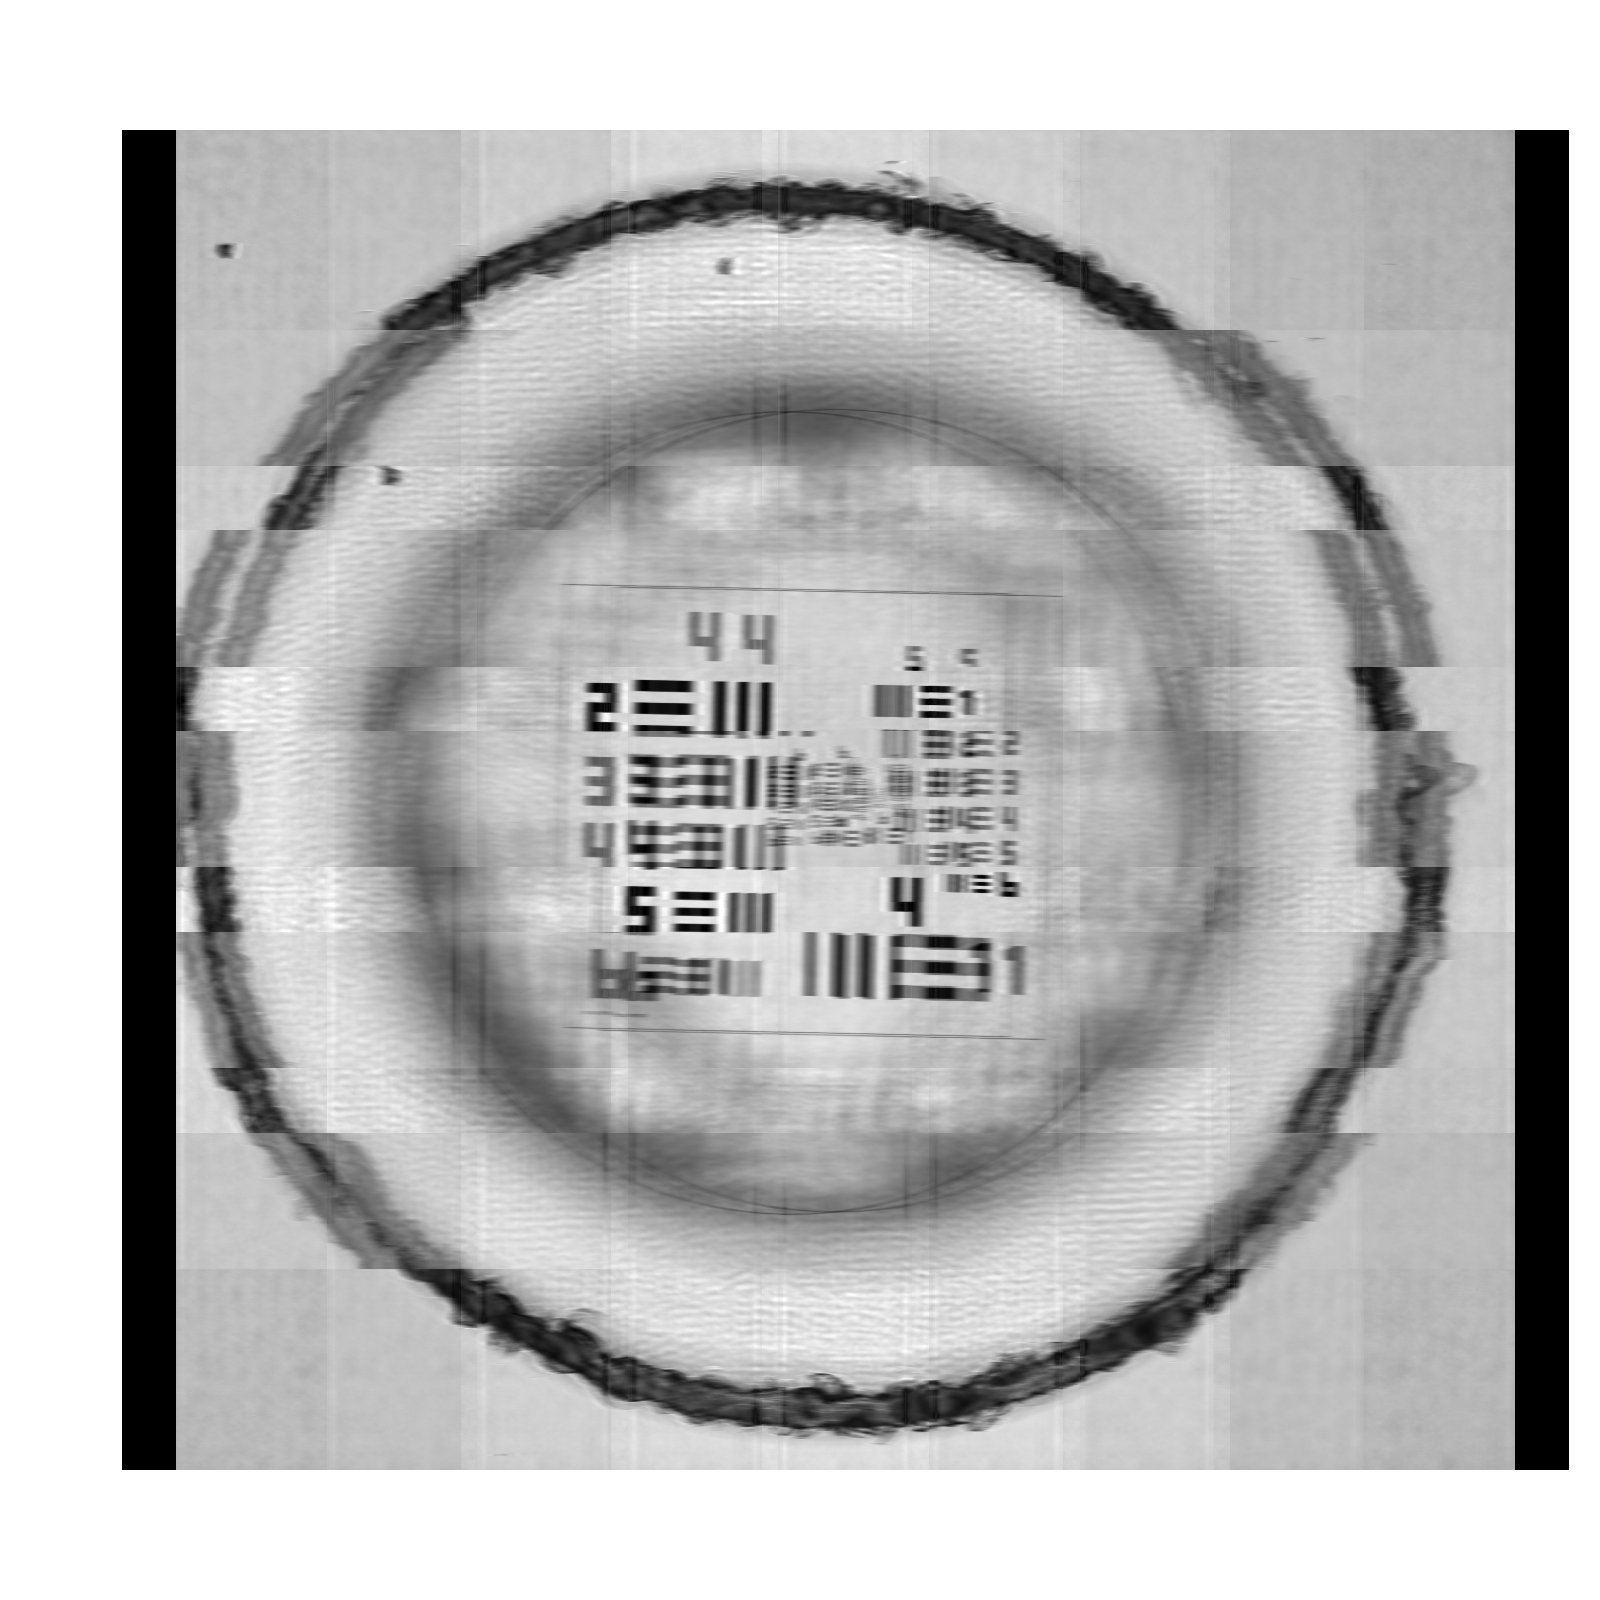

In [24]:
#     print(frame_index)
plt.figure(figsize=(10,10))
im = plt.imshow(obj, cmap='gray', vmax=45000)
plt.axis('off')
plt.tight_layout()
# plt.savefig(fig_dir + '/' + sample_name + '.png', transparent=True, dpi=200)

In [20]:
import sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

fig, ax = plt.subplots()
fig.set_tight_layout(True)

# Query the figure's on-screen size and DPI. Note that when saving the figure to
# a file, we need to provide a DPI for that separately.
print('fig size: {0} DPI, size in inches {1}'.format(
    fig.get_dpi(), fig.get_size_inches()))

position_list = []
for frame_index in range(len(dataset.frame_list)):
    position_dict = dataset.frame_state_list[frame_index]['position'][0][0]['value']
    position_list.append(np.round(np.asarray((position_dict['x'], position_dict['y'])) / (dataset.metadata.system.eff_pixel_size_um/1000)).astype(np.int))
    
position_list = np.asarray(position_list)

sample_name = 'usaf'
fg_color = 'red'
bg_color = 'cyan'

def update(i):
    label = 'timestep {0}'.format(i)
    print(label)
    # Update the line and the axes (with a new xlabel). Return a tuple of
    # "artists" that have to be redrawn for this frame.
    line.set_ydata(x - 5 + i)
    ax.set_xlabel(label)
    return line, ax

if __name__ == '__main__':
    # FuncAnimation will call the 'update' function for each frame; here
    # animating over 10 frames, with an interval of 200ms between frames.
    anim = FuncAnimation(fig, update, frames=np.arange(0, 10), interval=200)
    if len(sys.argv) > 1 and sys.argv[1] == 'save':
        anim.save('line.gif', dpi=80, writer='imagemagick')
    else:
        # plt.show() will just loop the animation forever.
        plt.show()

IndentationError: expected an indented block (<ipython-input-20-bffe45448d02>, line 42)

<IPython.core.display.Javascript object>


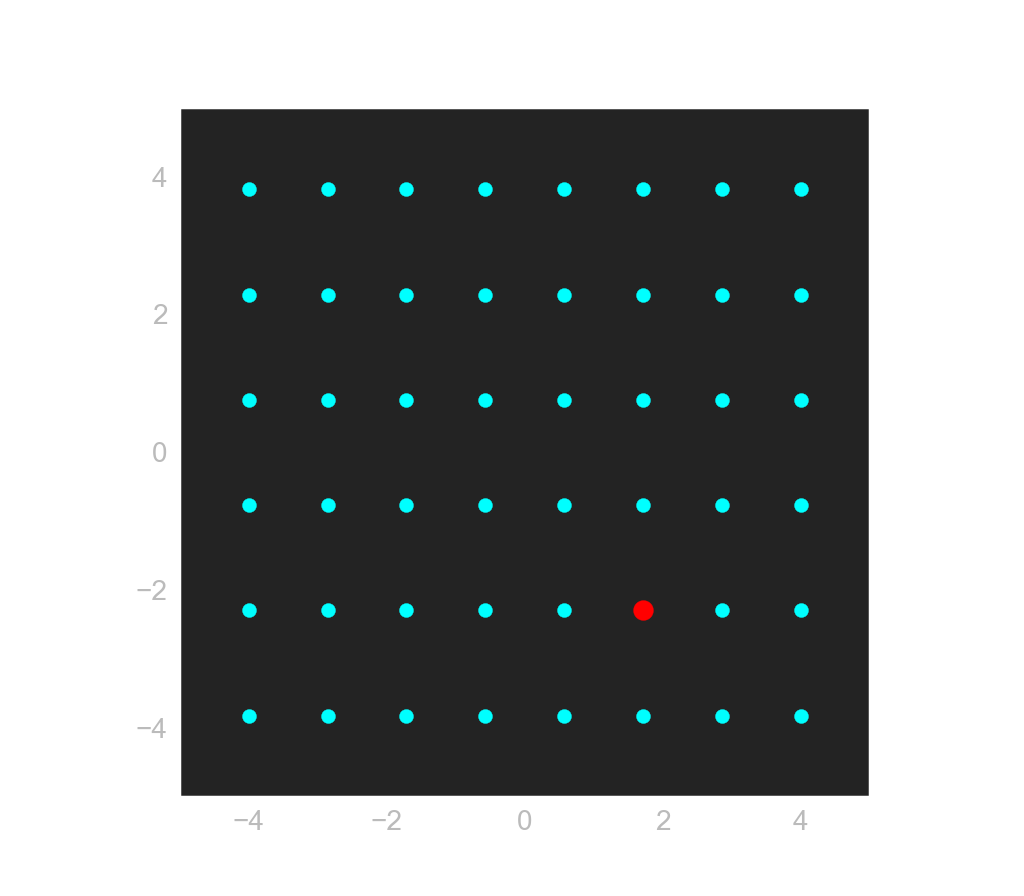

In [26]:
from matplotlib.animation import FuncAnimation
position_list = []
for frame_index in range(len(dataset.frame_list)):
    position_dict = dataset.frame_state_list[frame_index]['position'][0][0]['value']
    position_list.append(np.round(np.asarray((position_dict['x'], position_dict['y'])) / (dataset.metadata.system.eff_pixel_size_um/1000)).astype(np.int))
    
position_list = np.asarray(position_list)

sample_name = 'usaf'
fg_color = 'red'
bg_color = 'cyan'

fig = plt.figure()

s1 = plt.scatter(position_list[:,0] / 1000, -1 * position_list[:,1] / 1000, c=bg_color, s=40)
s2 = plt.scatter(position_list[highlight_index, 0] / 1000, -1 * position_list[highlight_index, 1] / 1000, c=fg_color, s=80)

plt.xlabel('Position (mm)')
plt.ylabel('Position (mm)')
ax = plt.gca()
ax.set_aspect(1)

plt.xlim([-5,5])
plt.ylim([-5,5])

# Set bg to transparent
fig.patch.set_alpha(0.)

# highlight_index=1
# s2.set_offsets([position_list[highlight_index, 0] / 1000, -1 * position_list[highlight_index, 1] / 1000])

def update(highlight_index):
    s2.set_offsets([position_list[highlight_index, 0] / 1000, -1 * position_list[highlight_index, 1] / 1000])
    fig.patch.set_alpha(0.)
    
anim = FuncAnimation(fig, update, frames=np.arange(0,position_list.shape[0]), interval=300, blit=True)
anim.save('line.gif', dpi=80, writer='imagemagick', savefig_kwargs={'transparent': True, 'facecolor': 'none'})

In [16]:
sample_name='usaf'

<IPython.core.display.Javascript object>


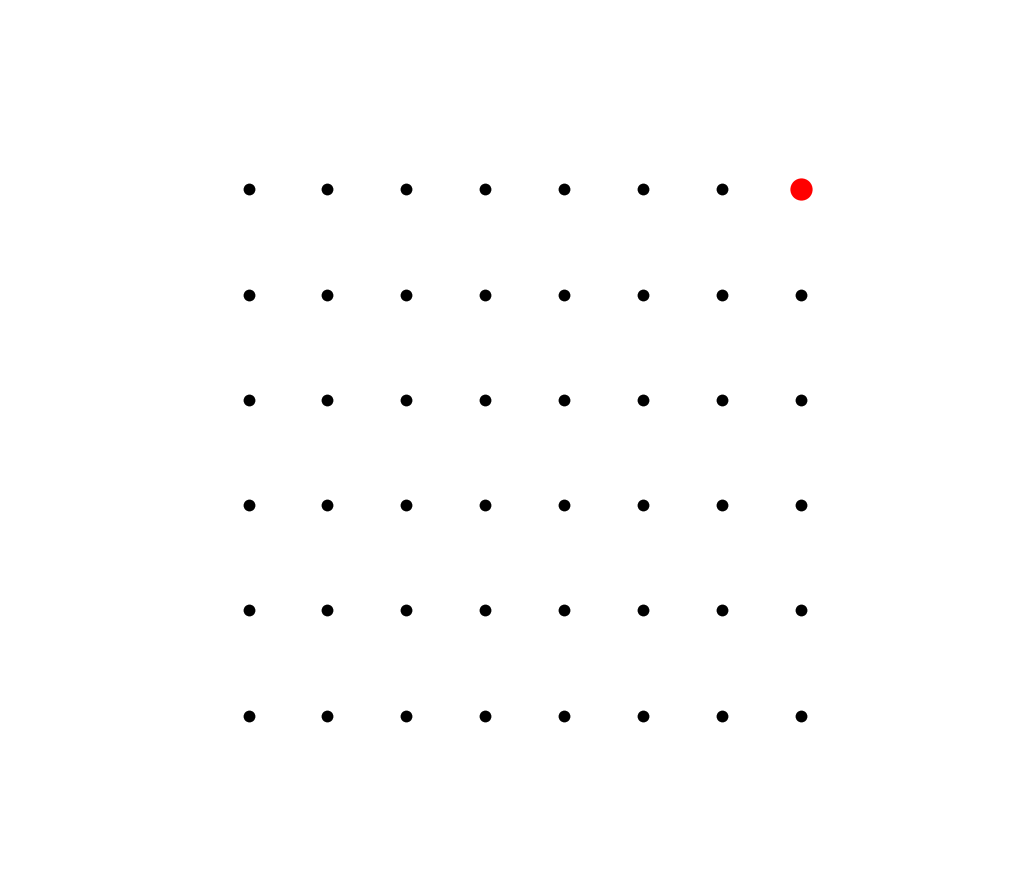

<IPython.core.display.Javascript object>


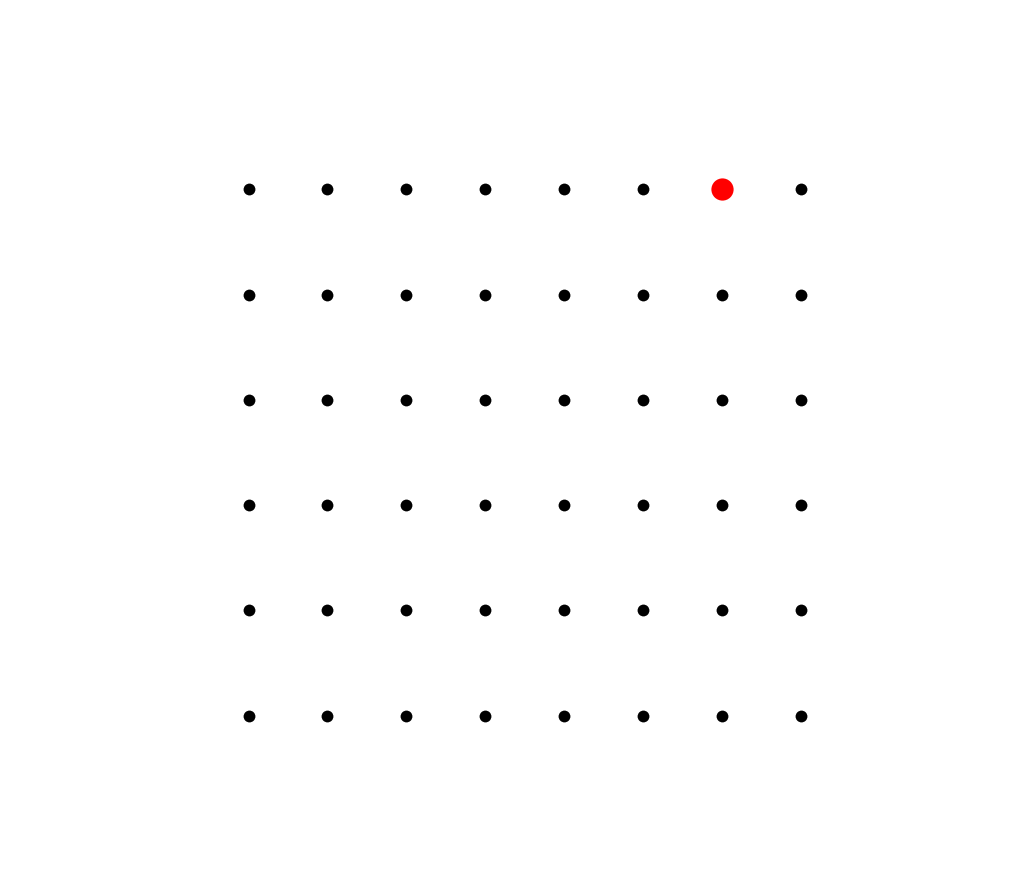

<IPython.core.display.Javascript object>


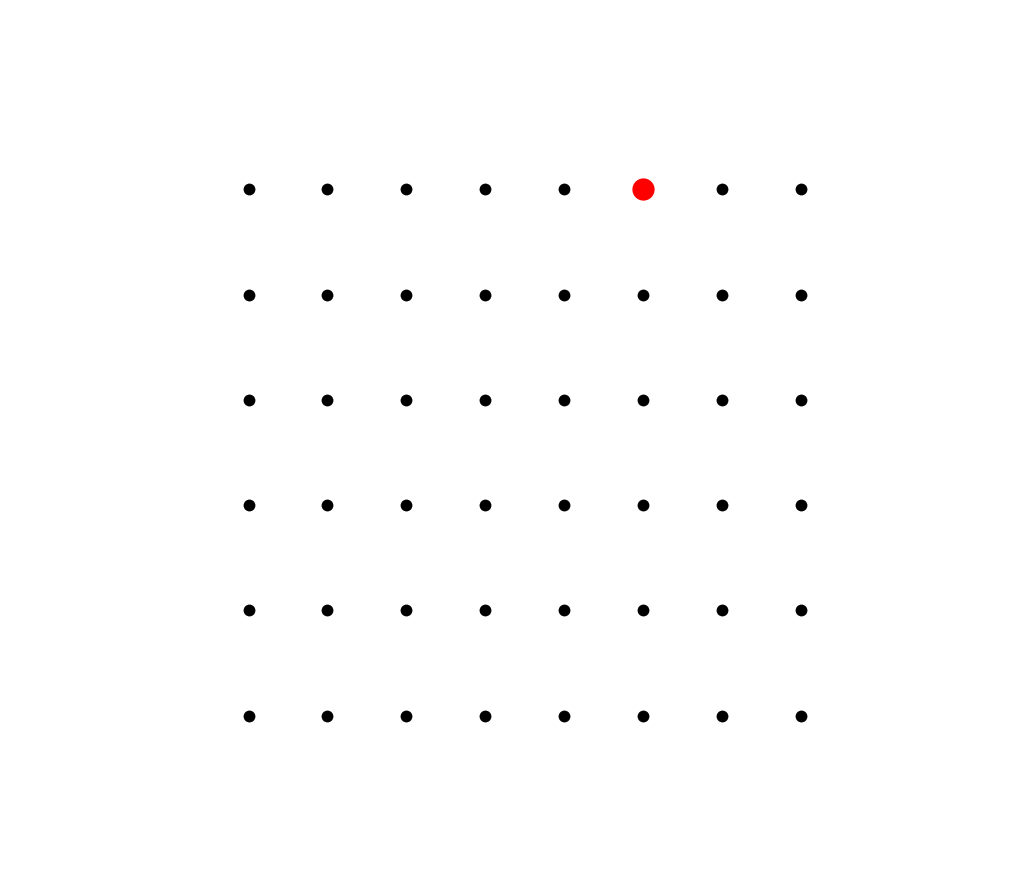

<IPython.core.display.Javascript object>


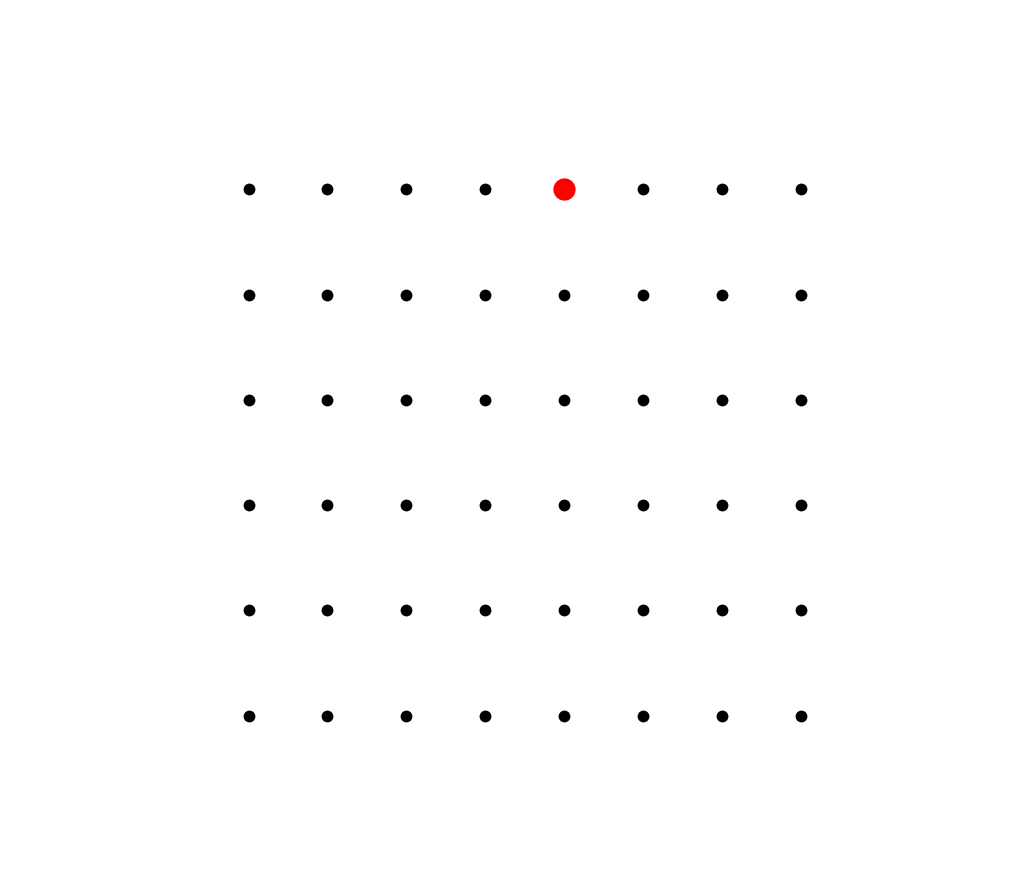

<IPython.core.display.Javascript object>


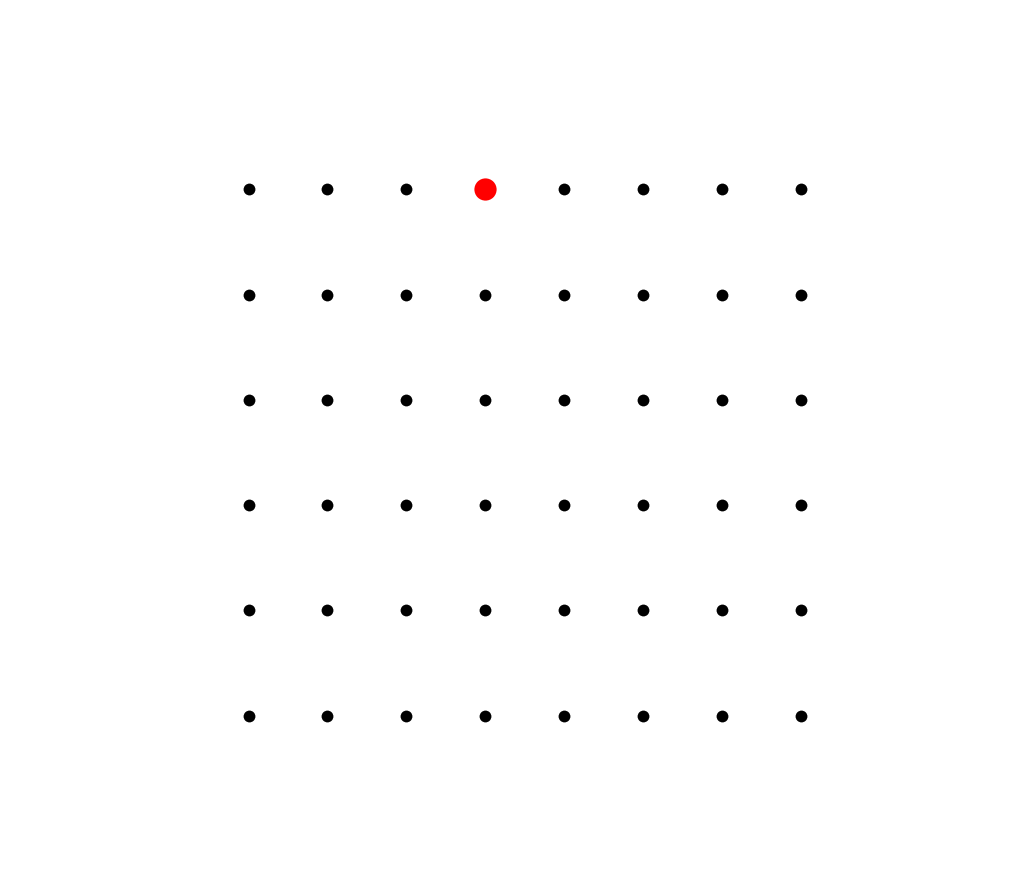

<IPython.core.display.Javascript object>


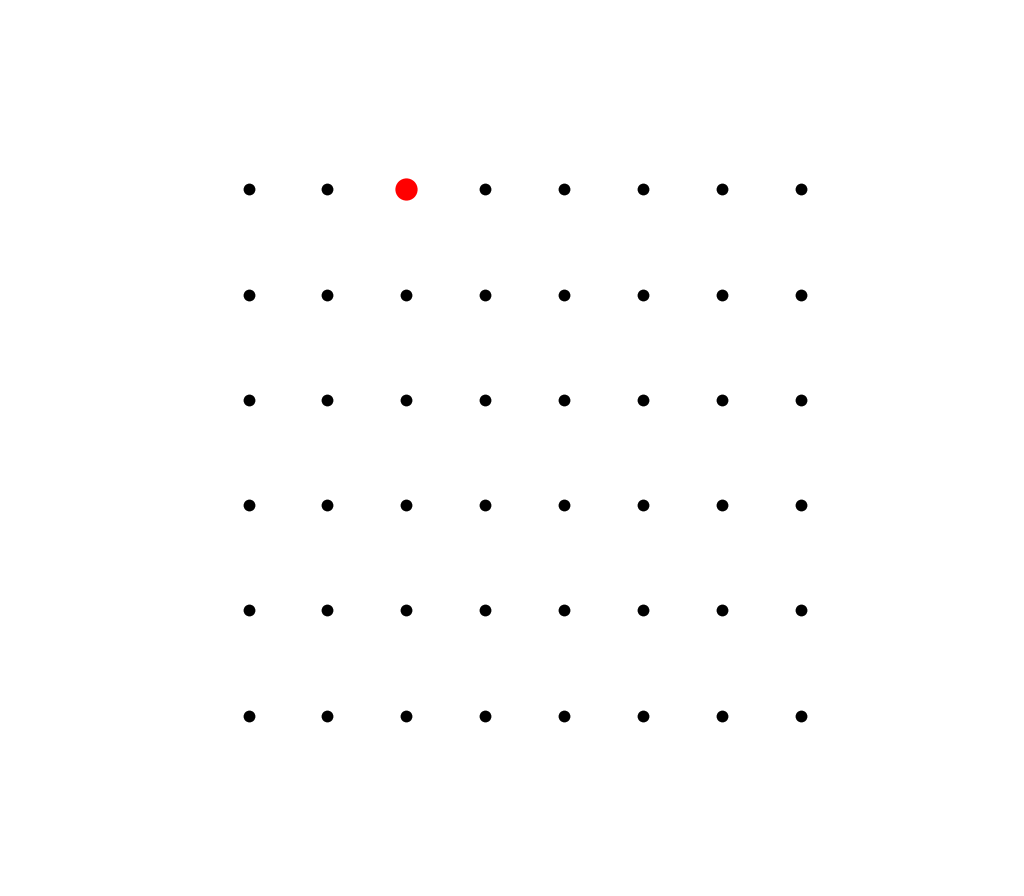

<IPython.core.display.Javascript object>


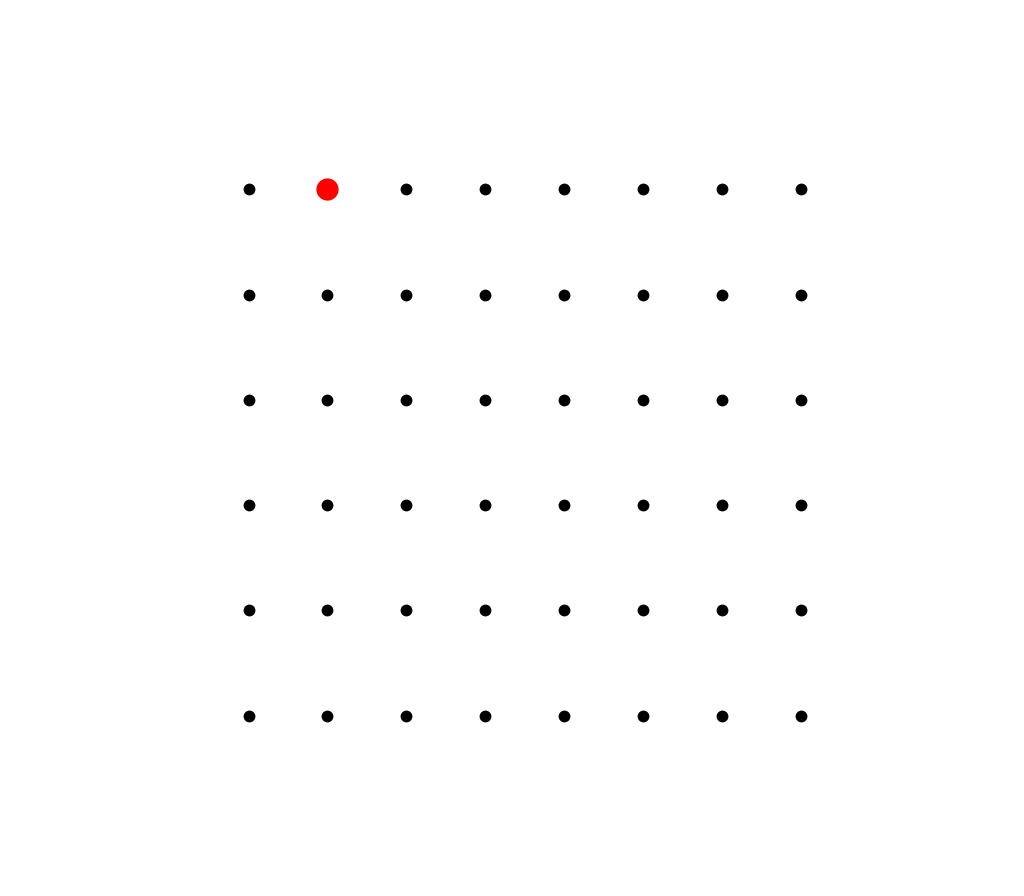

<IPython.core.display.Javascript object>


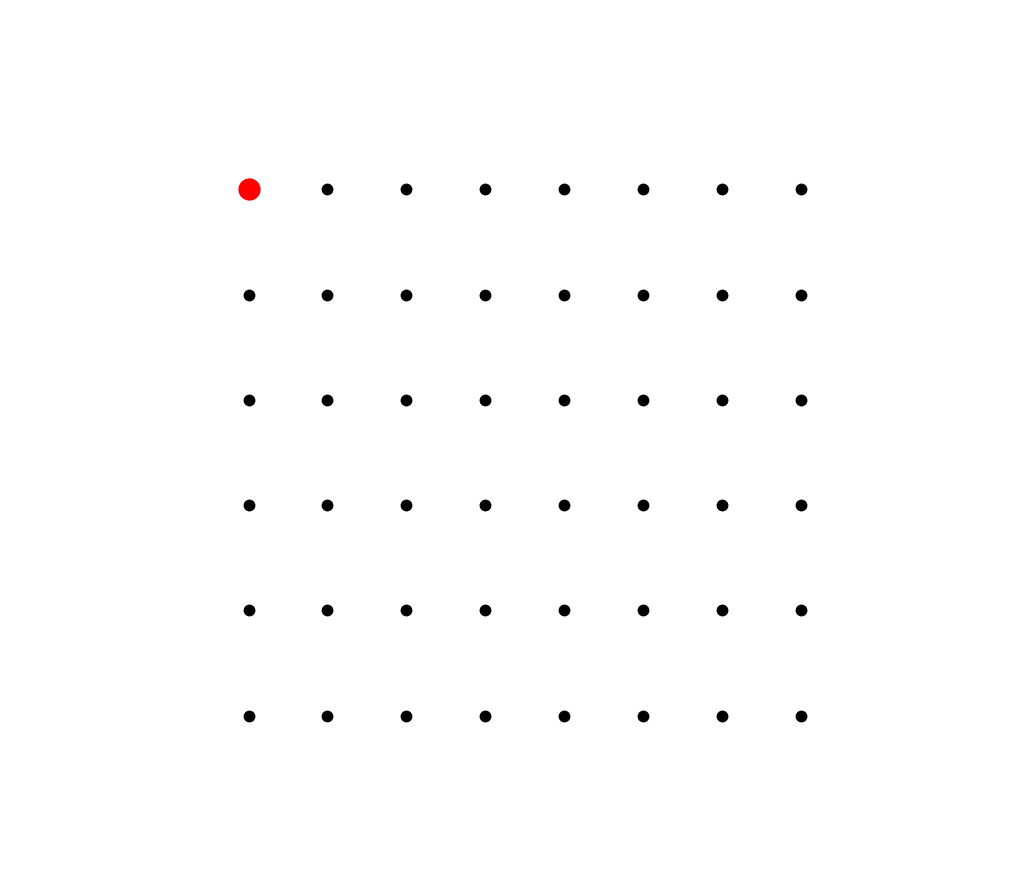

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


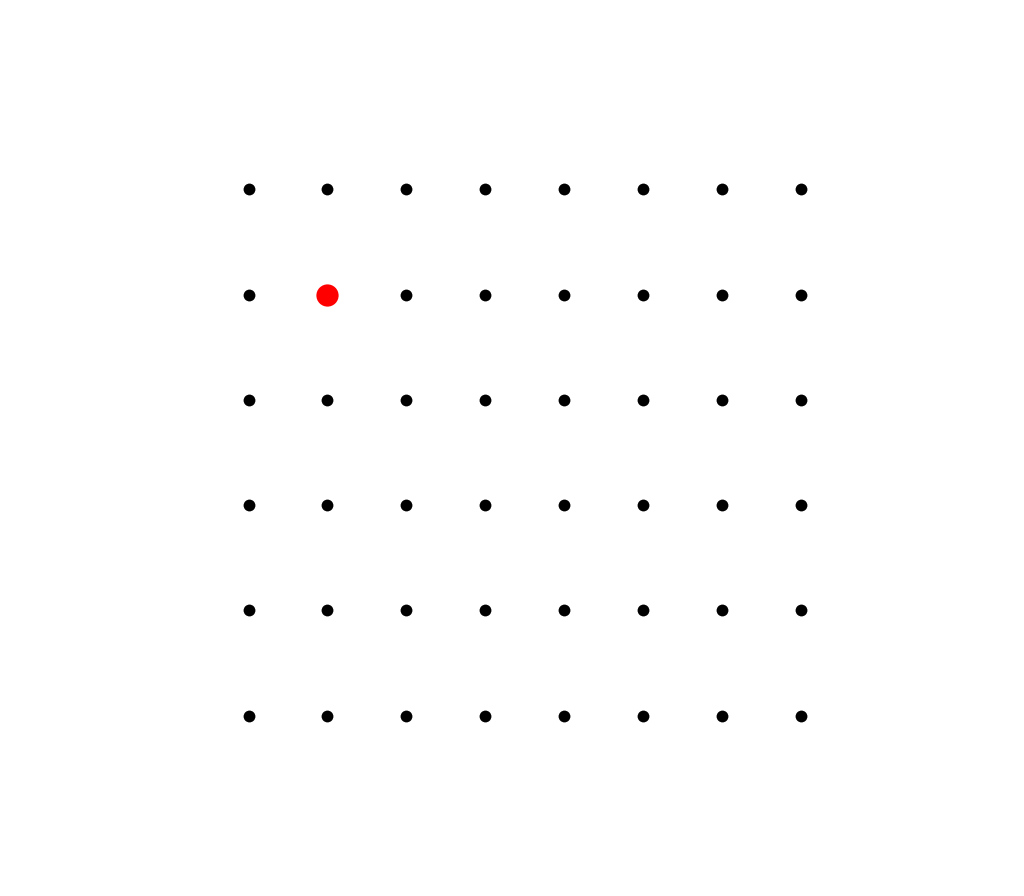

<IPython.core.display.Javascript object>


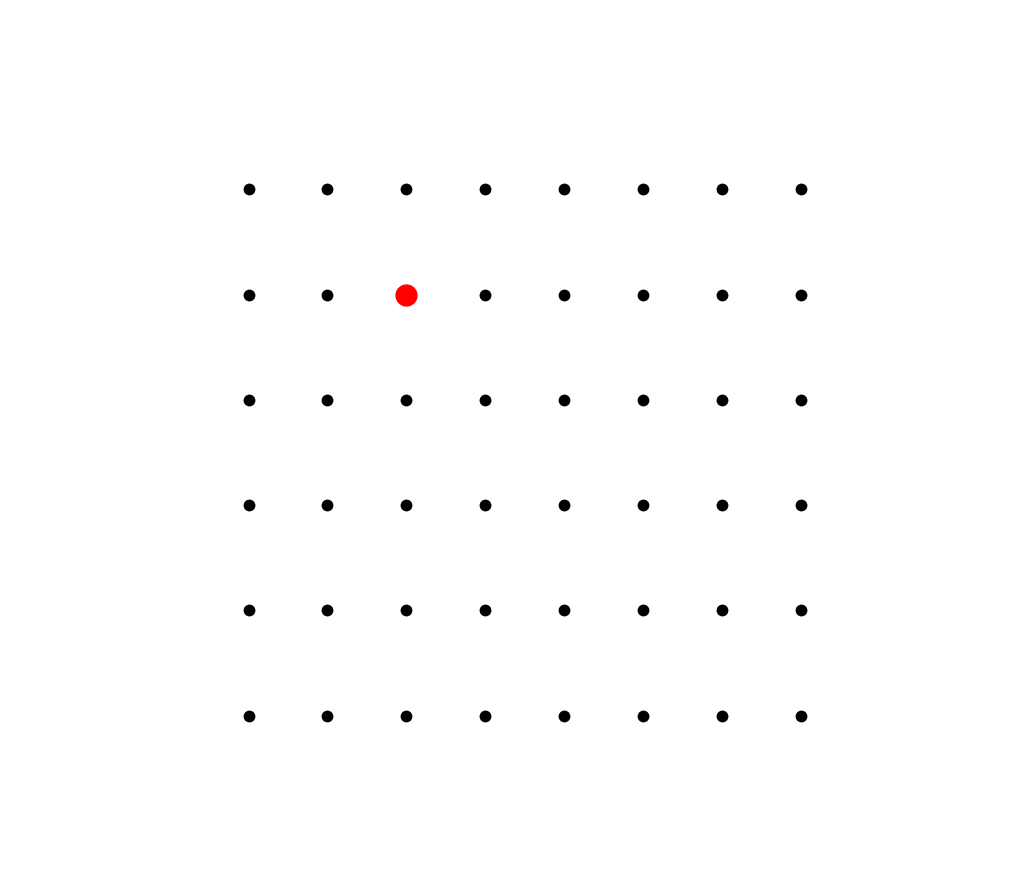

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


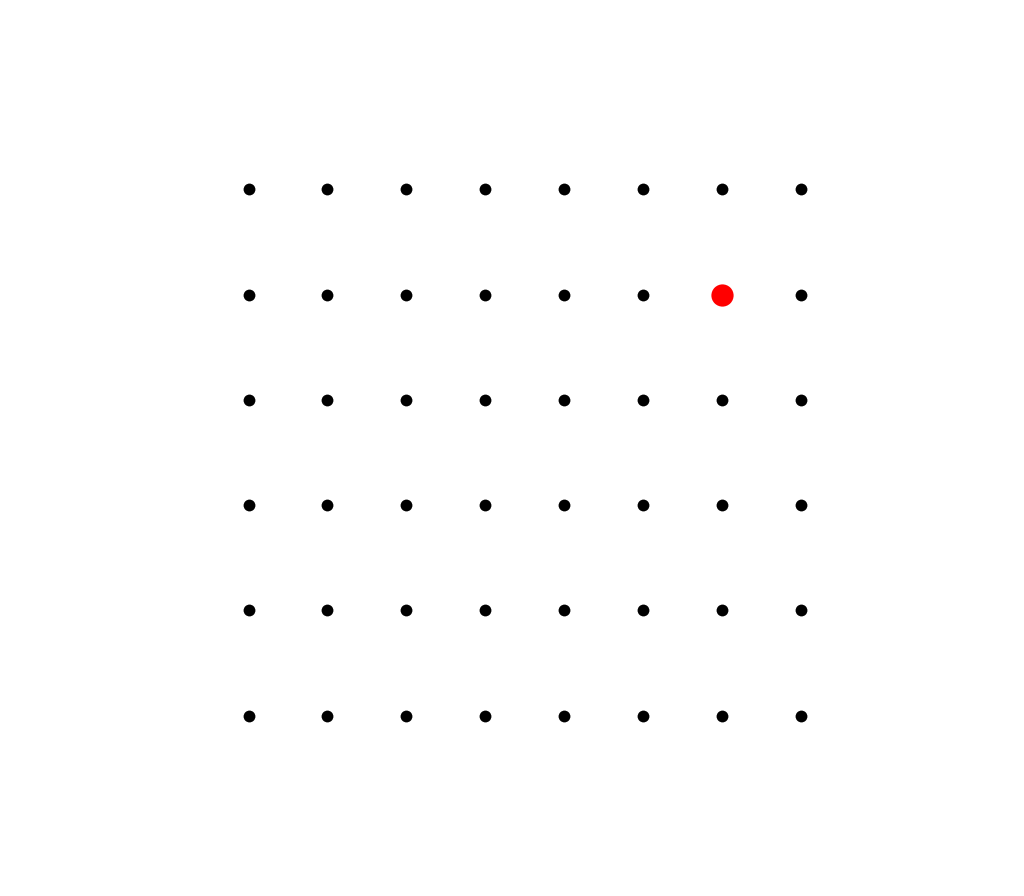

<IPython.core.display.Javascript object>


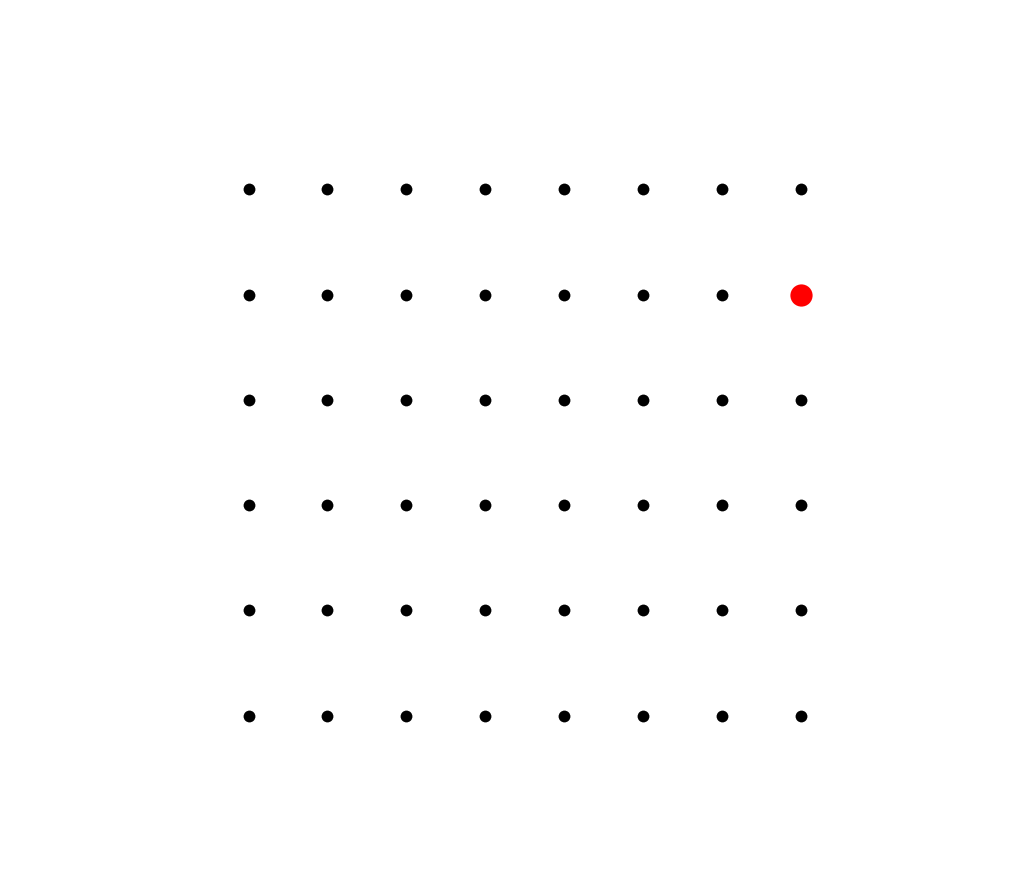

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


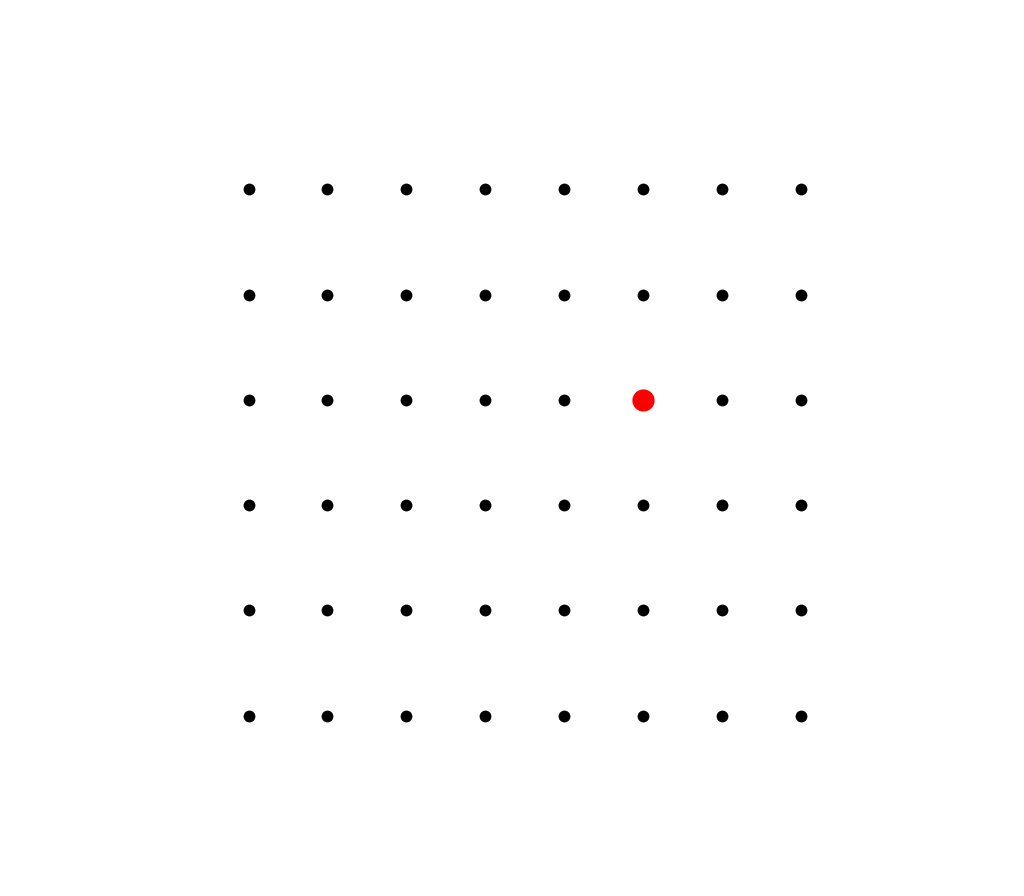

<IPython.core.display.Javascript object>


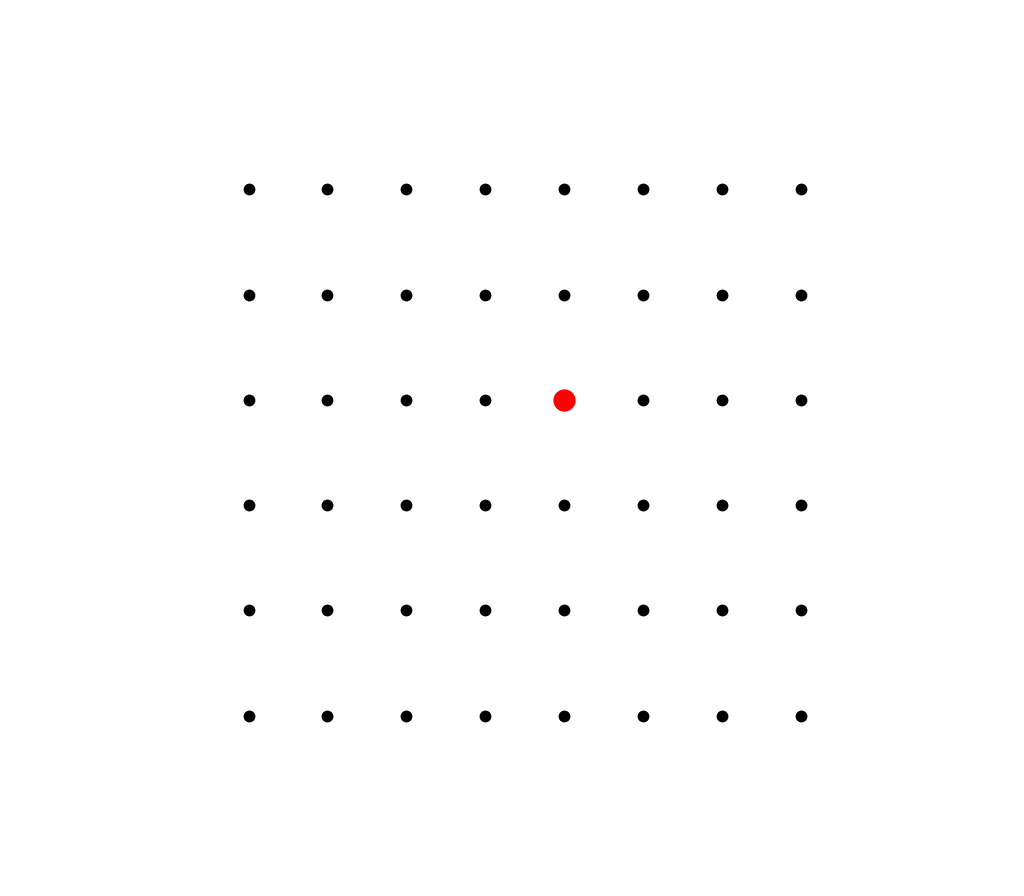

/Users/zfphil/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


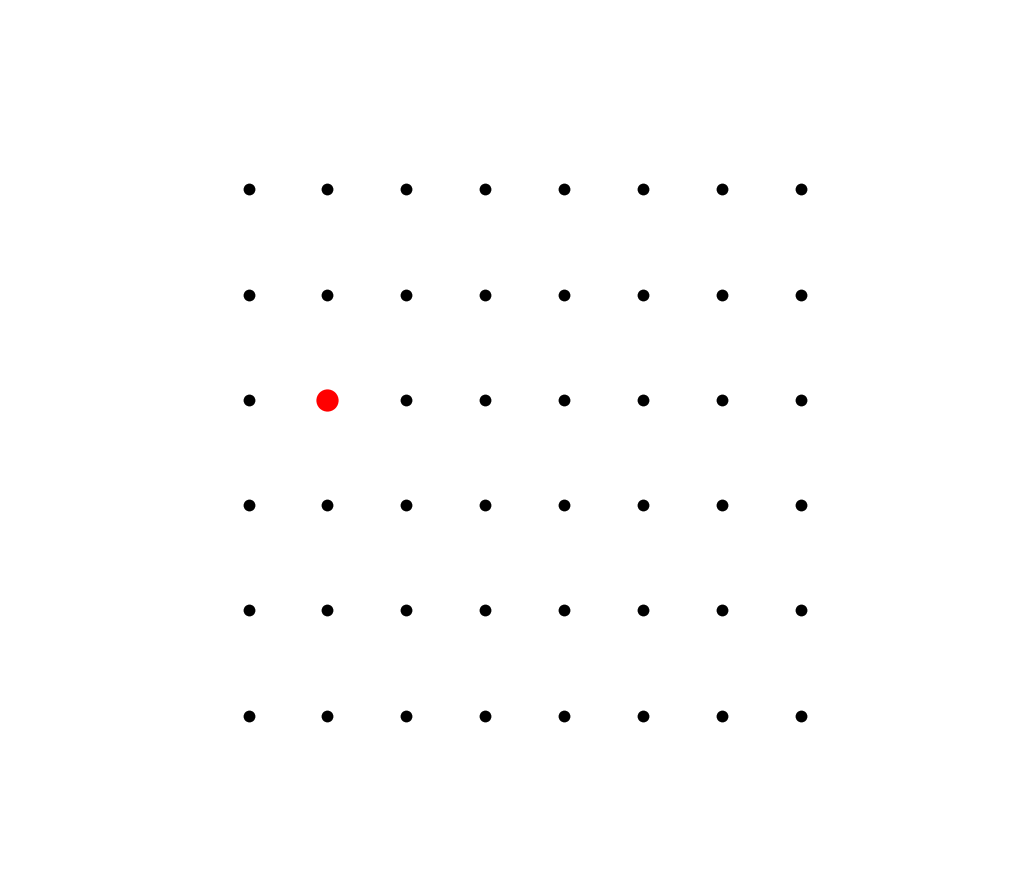

<IPython.core.display.Javascript object>


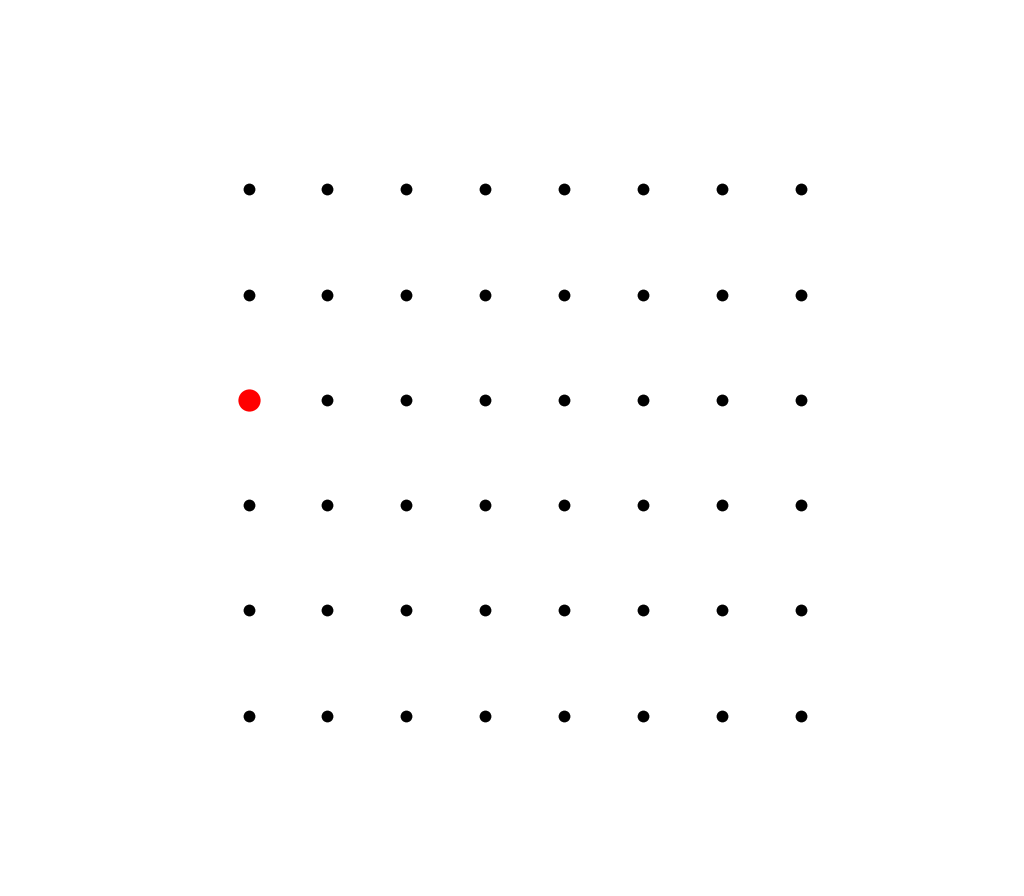

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


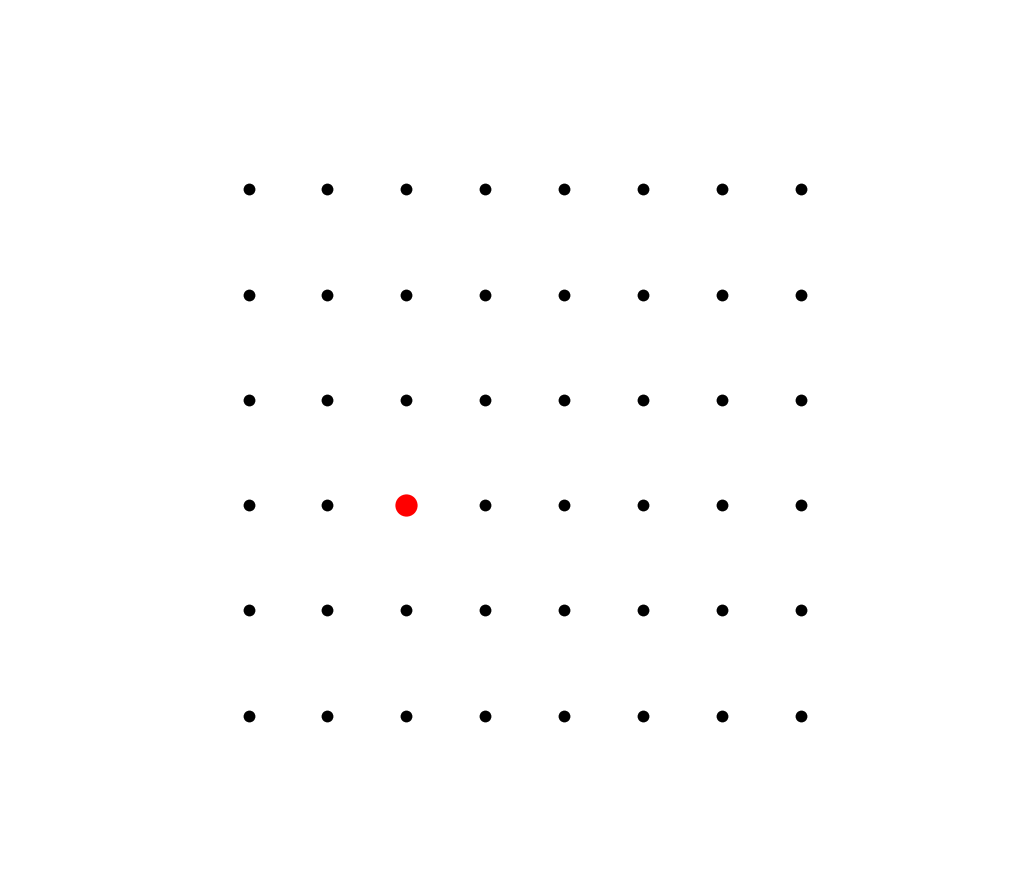

<IPython.core.display.Javascript object>


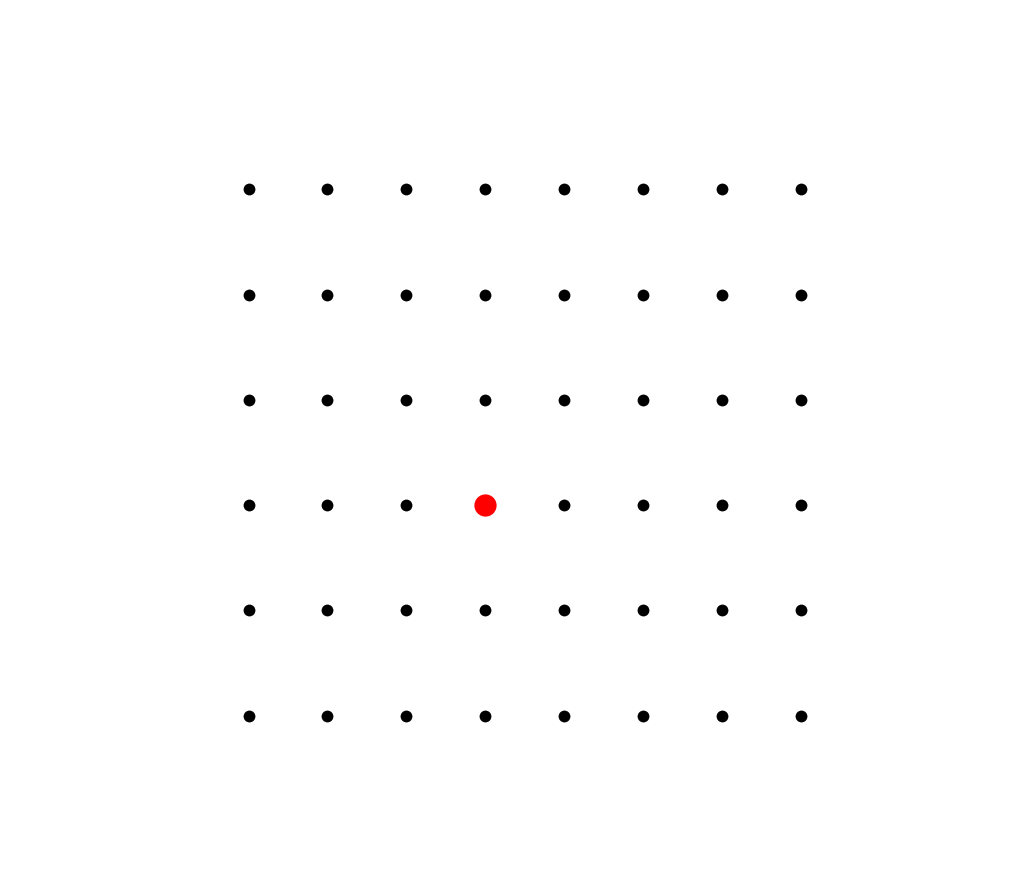

<IPython.core.display.Javascript object>


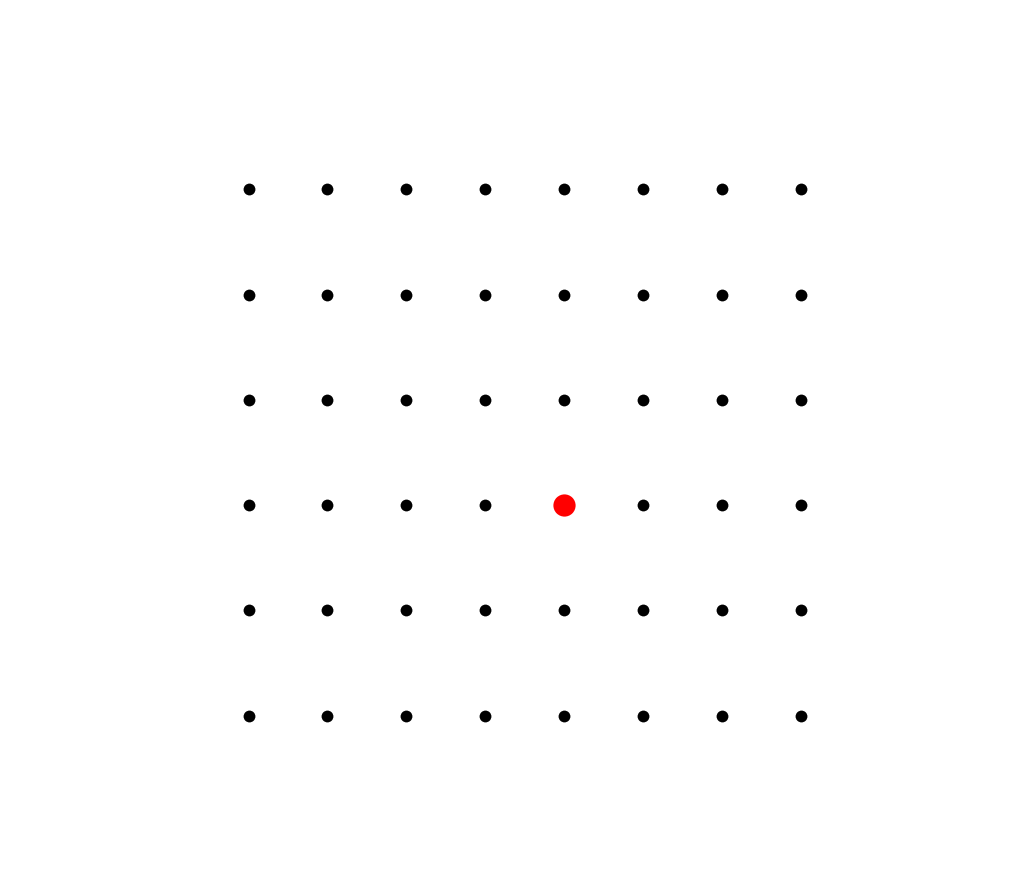

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


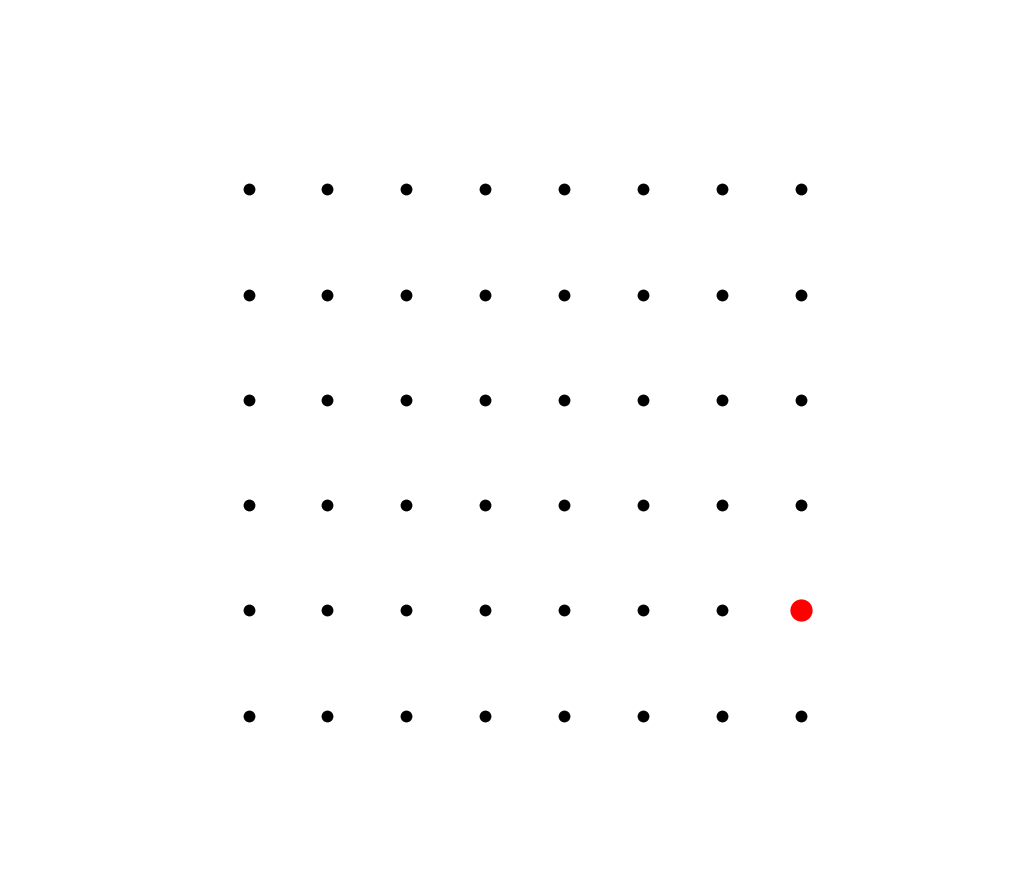

<IPython.core.display.Javascript object>


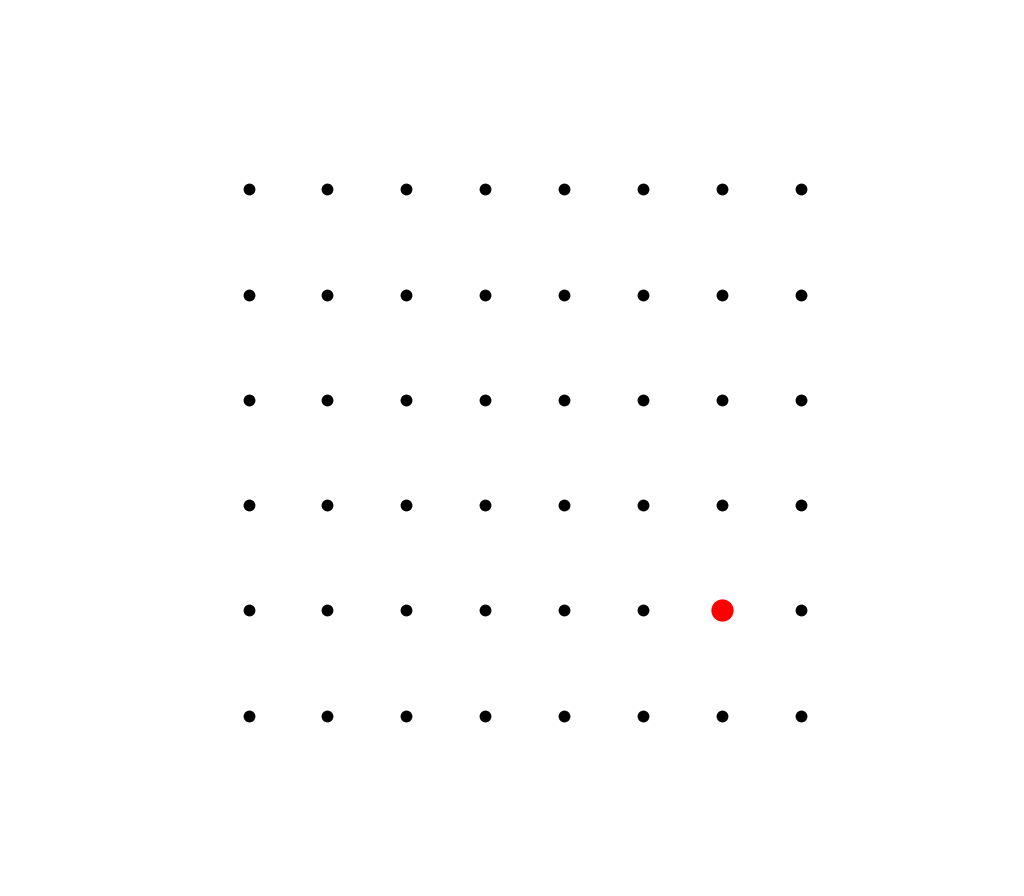

<IPython.core.display.Javascript object>


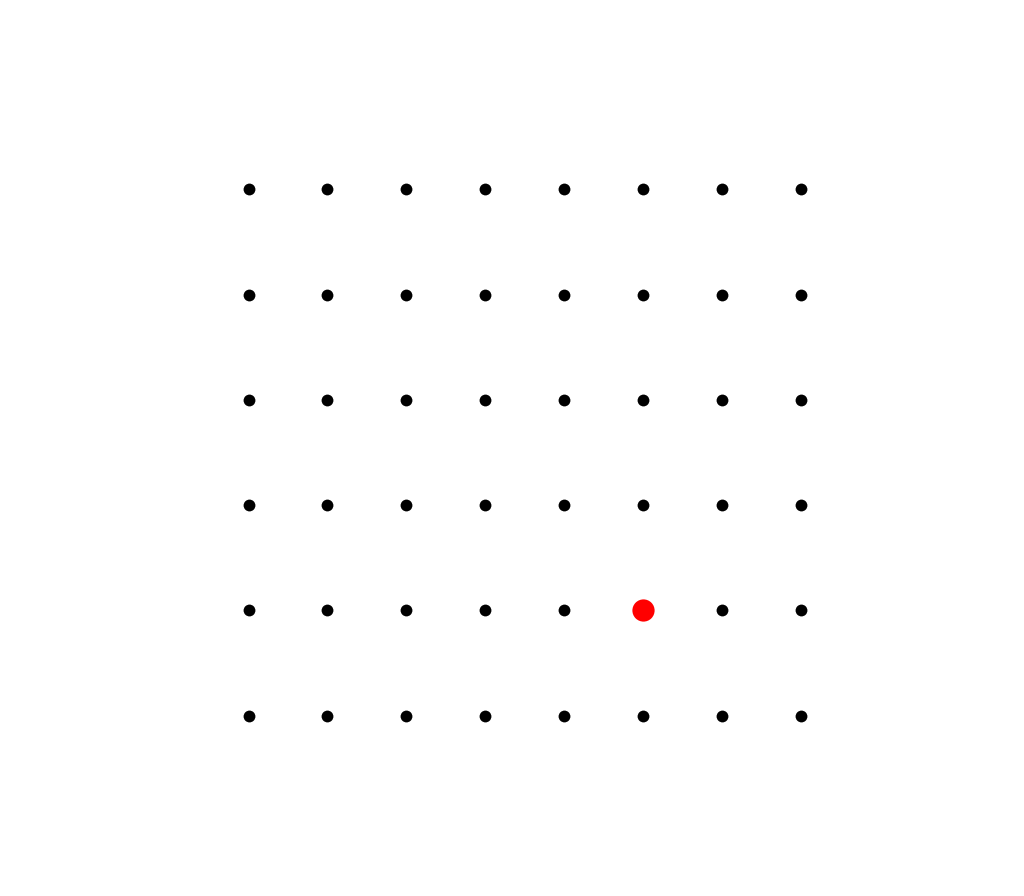

<IPython.core.display.Javascript object>


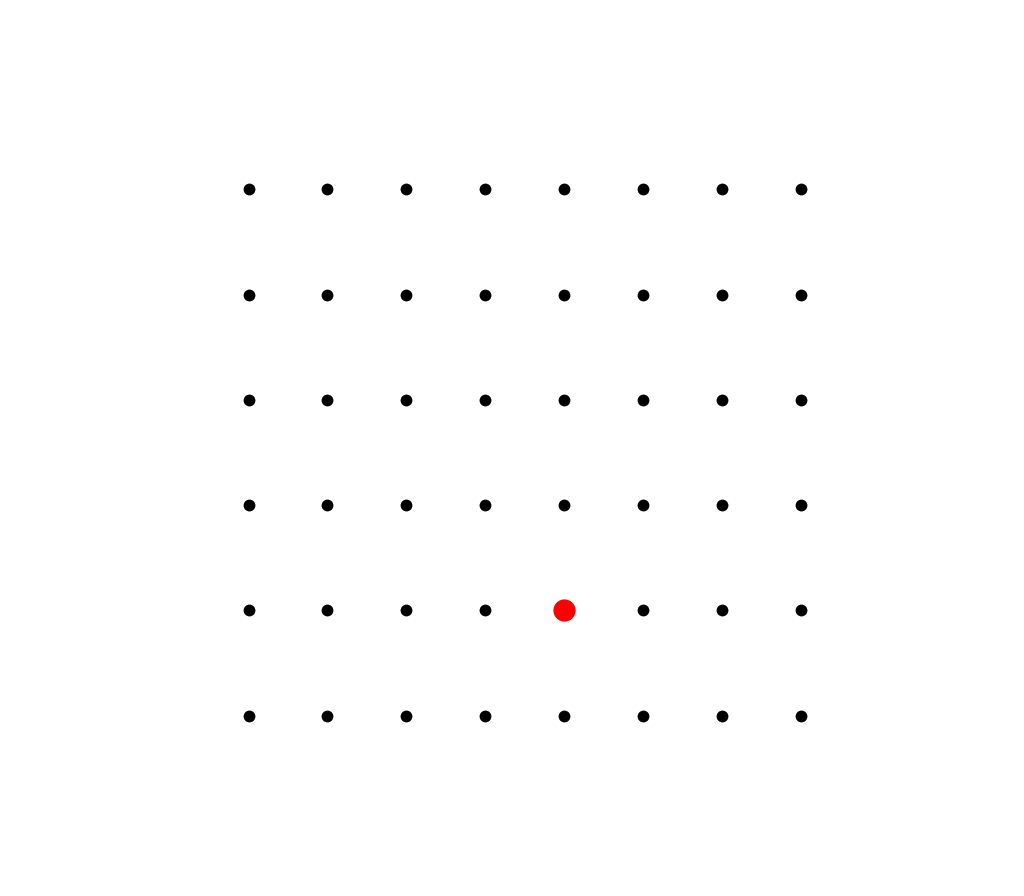

<IPython.core.display.Javascript object>


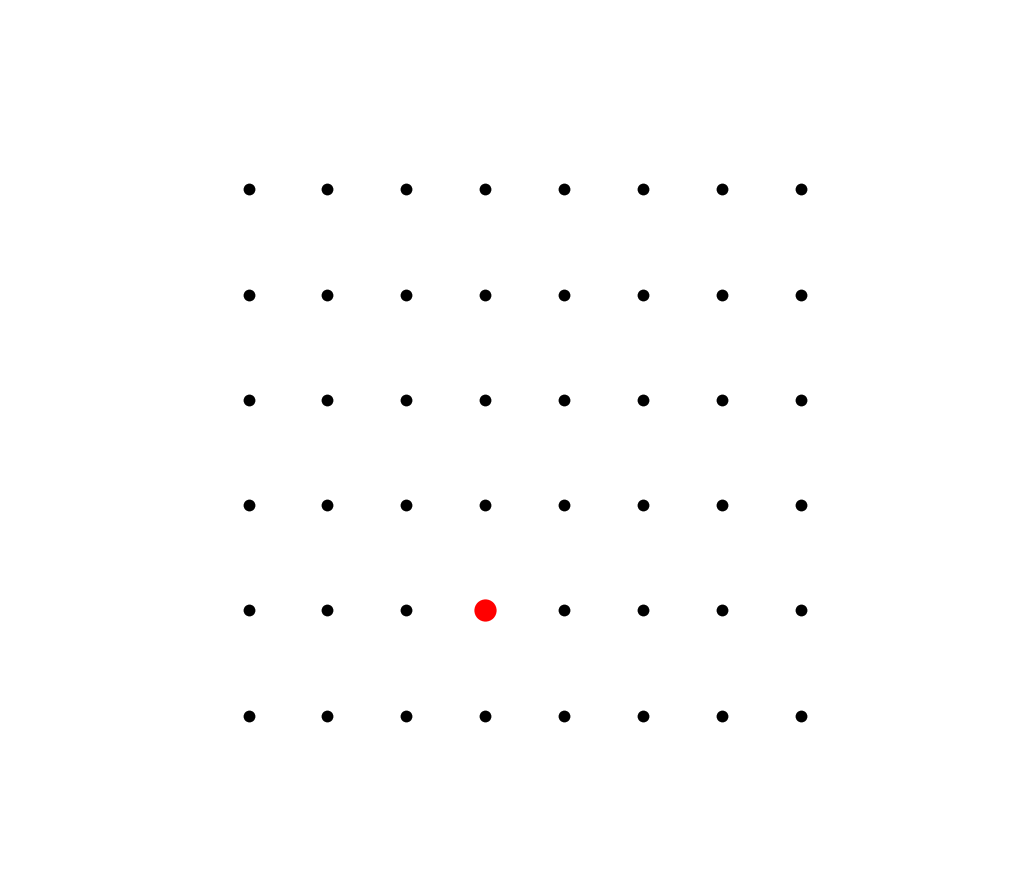

<IPython.core.display.Javascript object>


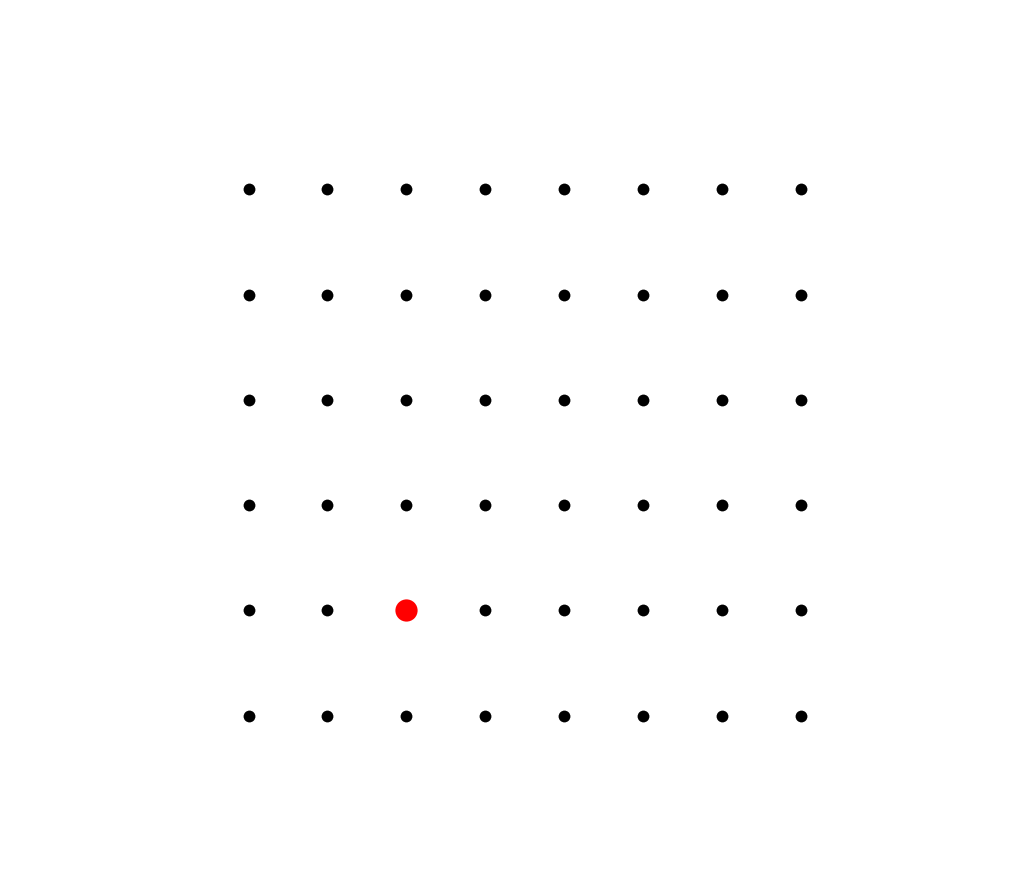

<IPython.core.display.Javascript object>


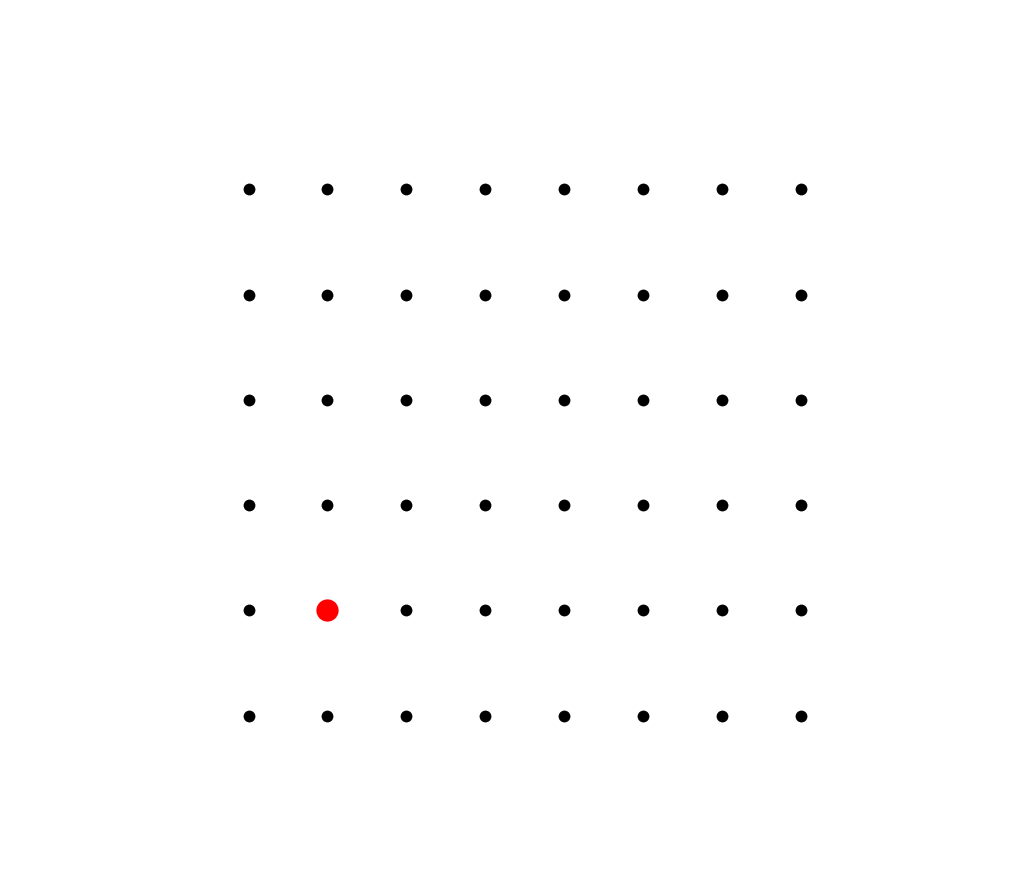

<IPython.core.display.Javascript object>


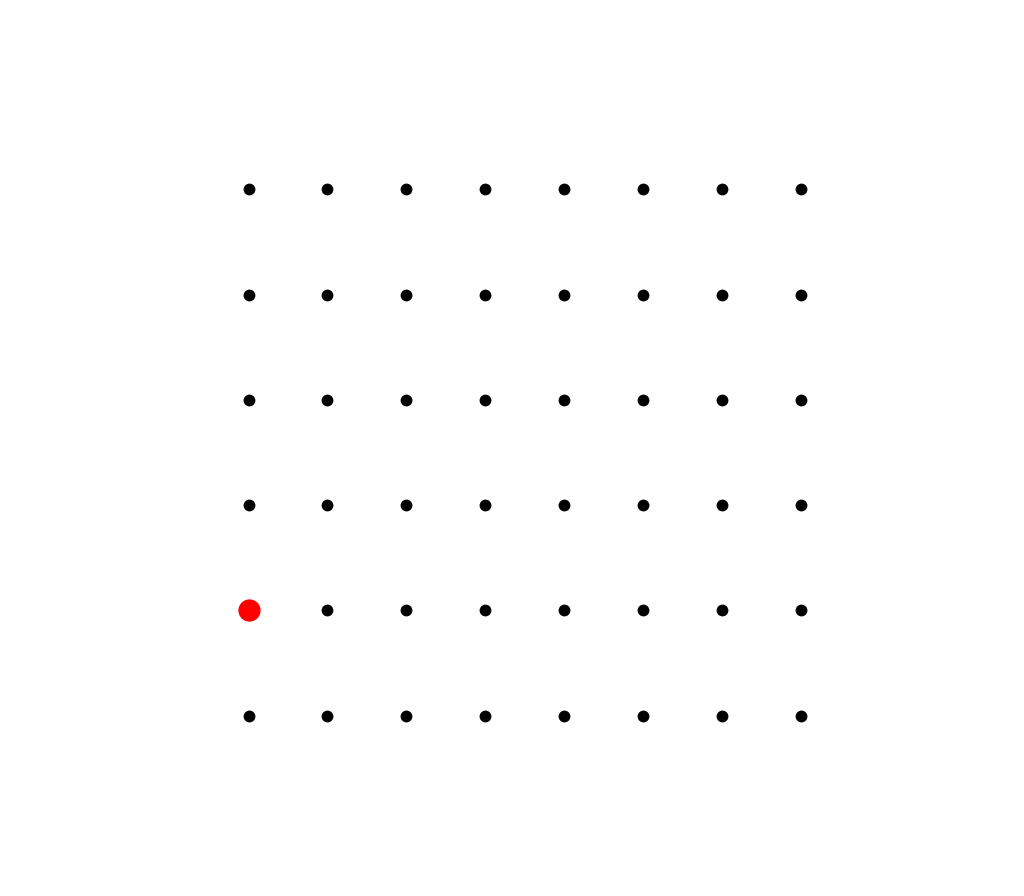

<IPython.core.display.Javascript object>


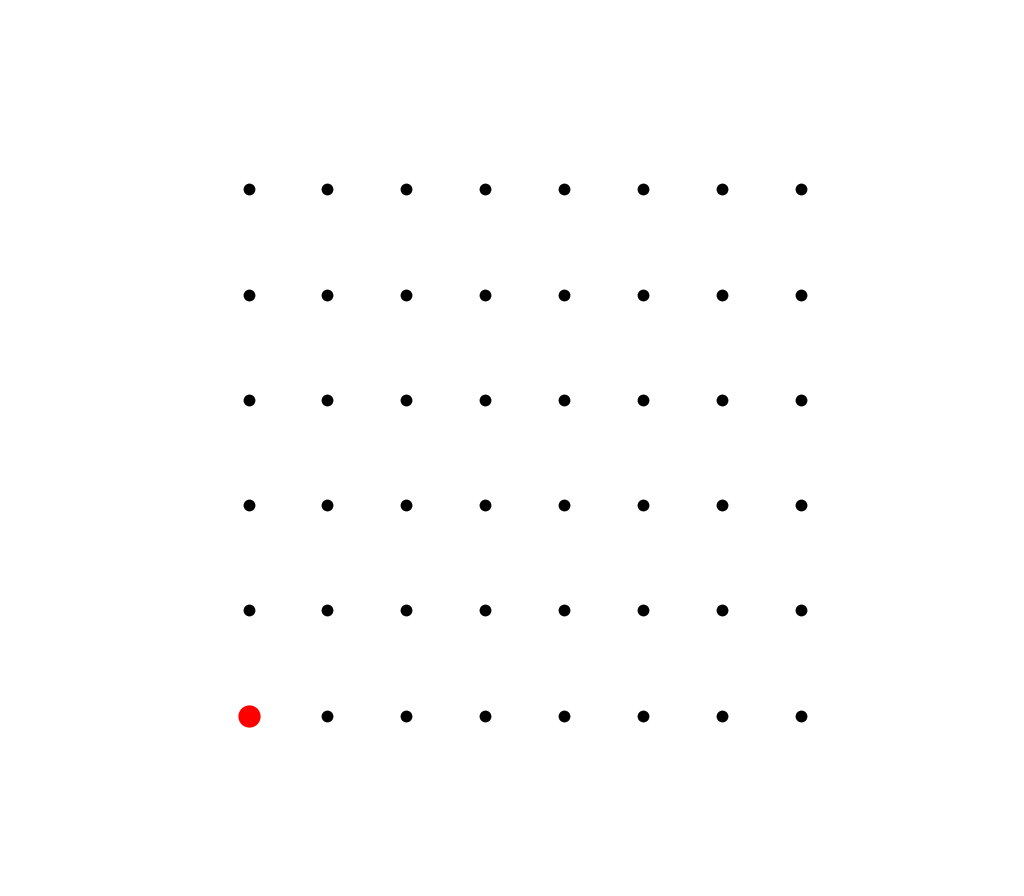

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


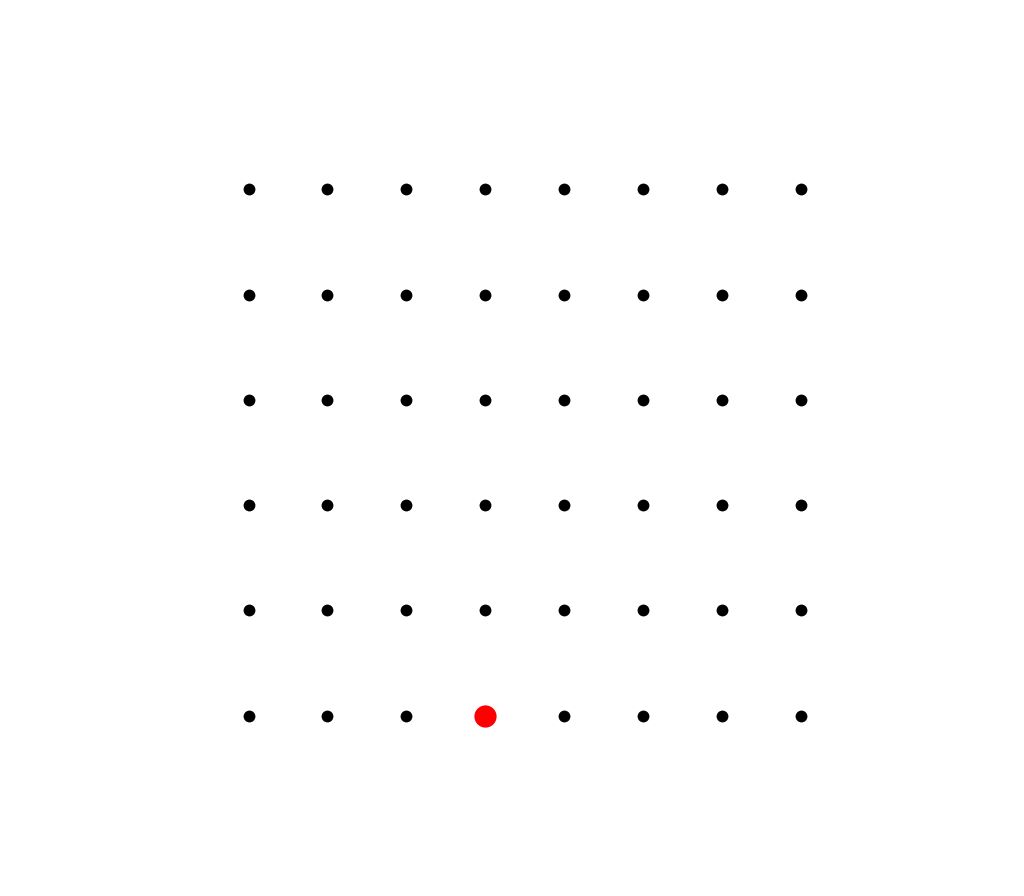

<IPython.core.display.Javascript object>


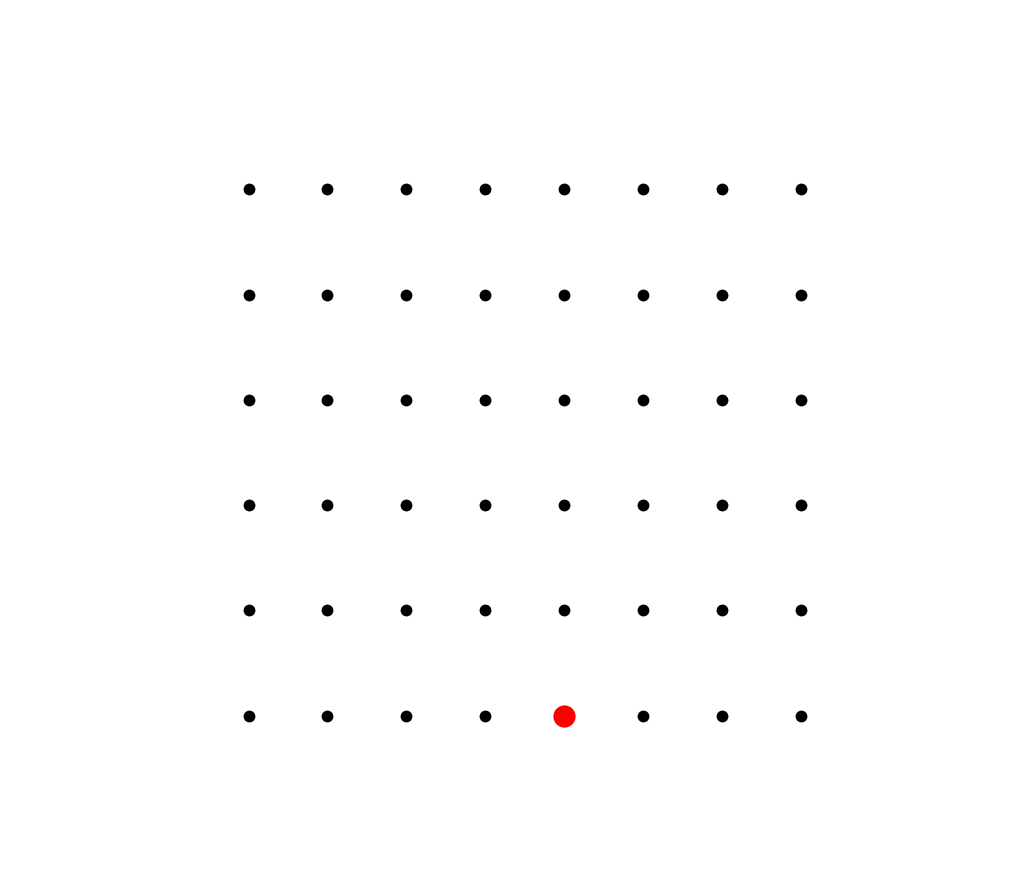

<IPython.core.display.Javascript object>


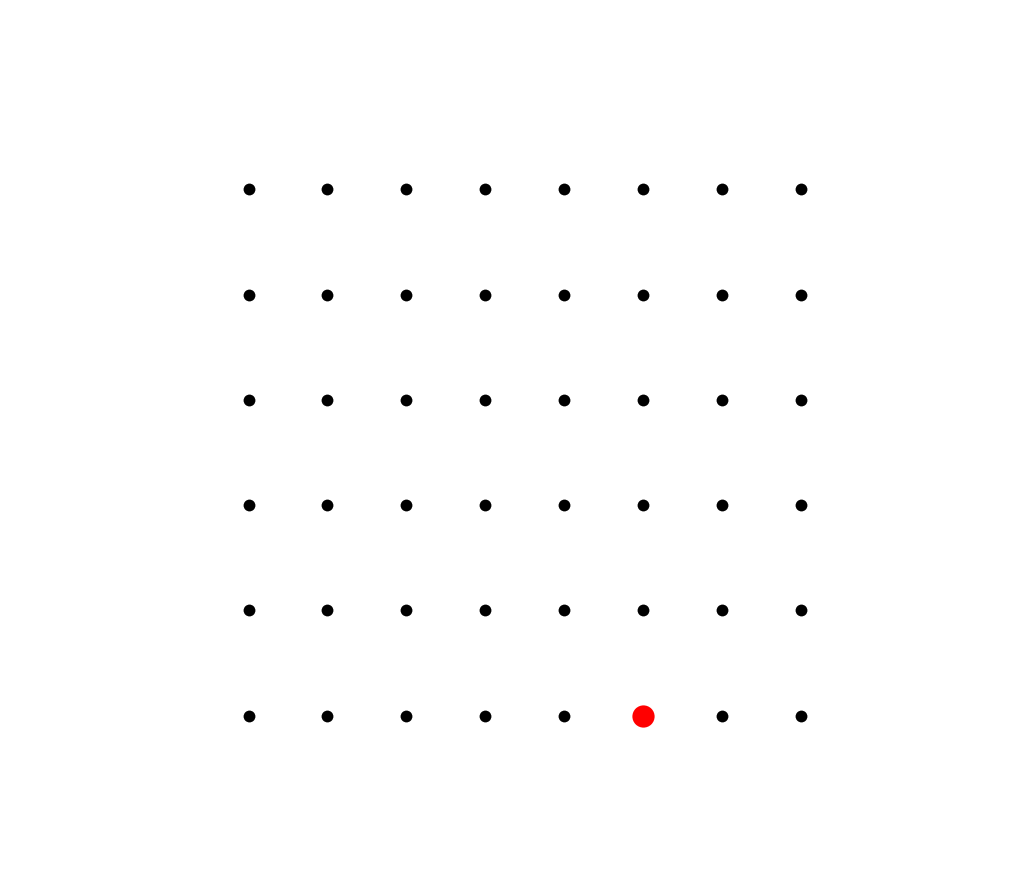

<IPython.core.display.Javascript object>


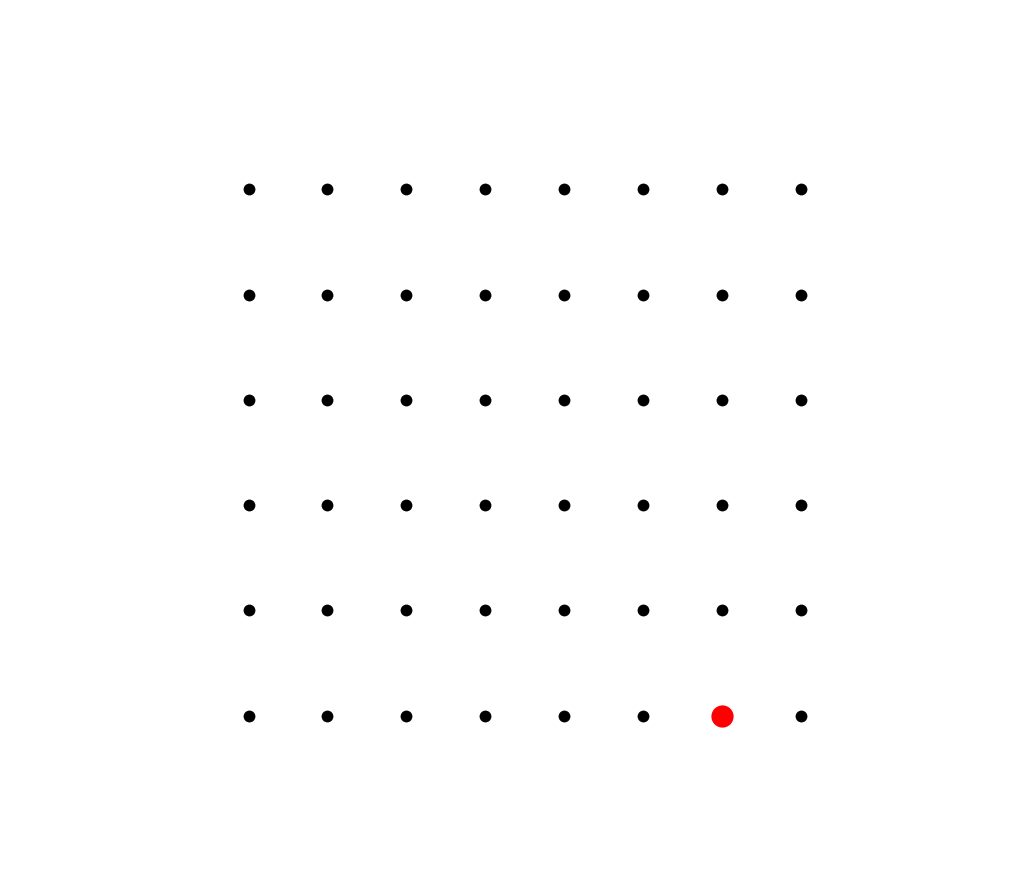

<IPython.core.display.Javascript object>


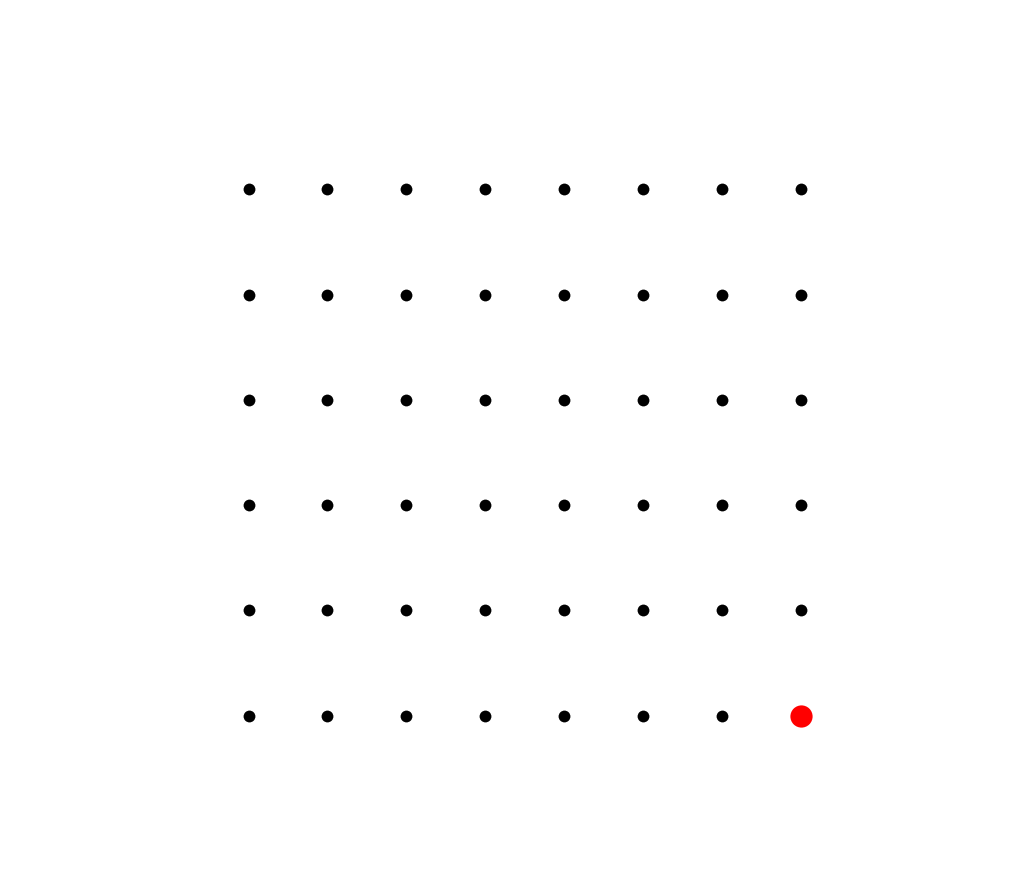

In [28]:
position_list = []
for frame_index in range(len(dataset.frame_list)):
    position_dict = dataset.frame_state_list[frame_index]['position'][0][0]['value']
    position_list.append(np.round(np.asarray((position_dict['x'], position_dict['y'])) / (dataset.metadata.system.eff_pixel_size_um/1000)).astype(np.int))
    
position_list = np.asarray(position_list)

fg_color = 'red'
bg_color = 'black'

for highlight_index in range(len(dataset.frame_list)):
    plt.figure()
#     im = plt.imshow(object_recon/ measurement_counts, cmap='gray')
    # plt.plot(position_list[:,0] / 1000, position_list[:,1] / 1000, c=bg_color, linewidth=2)
    plt.scatter(-position_list[:,0] / 1000, -1 * position_list[:,1] / 1000, c=bg_color, s=40, edgecolors='w', linewidths=1)
    plt.scatter(-position_list[highlight_index, 0] / 1000, -1 * position_list[highlight_index, 1] / 1000, c=fg_color, s=100, linewidths=0, edgecolors='w')

    plt.xlabel('Position (mm)')
    plt.ylabel('Position (mm)')
    ax = plt.gca()
    ax.set_aspect(1)

    plt.xlim([-5,5])
    plt.ylim([-5,5])
    plt.axis('off')
    # plt.scatter(position_list[highlight_index,0] / 1000, position_list[highlight_index,1] / 1000, c=fg_color, s=80)
    plt.savefig(fig_dir + '/pathways/' + sample_name + '_path_' + str(highlight_index) + '.png', transparent=True, dpi=200)

## Strobed


In [26]:
# flip_y = True
# flip_x = False
# transpose_measurements = True

# Stop and stare
flip_y = False
flip_x = True
transpose_measurements = False

# Get object_size, and image_size
(object_size, image_size, blur_kernel_list_color) = blurkernel.blurKernelsFromDataset(dataset, frame_list=[0], 
                                                                                      flip_kernel_y=flip_y, 
                                                                                      transpose_measurements=transpose_measurements)


# frames_to_stitch = range(len(dataset.frame_list))
obj_list = []
frame_groups = [np.arange(0,8), np.arange(8,16),  np.arange(16,24),  np.arange(24,32), np.arange(32,40), np.arange(40,48)]
for frames_to_stitch in frame_groups:
    measurement_counts = np.zeros(object_size, dtype=np.int)
    object_recon = np.zeros(object_size, dtype=np.float32)
    for frame_index in frames_to_stitch:
        # Get ideal shift from metadata
    #     position = position_list_corrected[frame_index, :].astype(np.int)
        position_dict = dataset.frame_state_list[frame_index]['position'][0][0]['value']
        position = np.round(np.asarray((position_dict['y'], position_dict['x'])) / (dataset.metadata.system.eff_pixel_size_um/1000)).astype(np.int)
        if flip_y:
            position[0] *= -1
        if flip_x:
            position[1] *= -1


    #     # Register images using cross-correlation
    #     if frame_index > 0:
    #         shift = opticstools.registerImage(dataset.frame_list[frame_index - 1].astype(np.float32), dataset.frame_list[frame_index].astype(np.float32))
    #         print(shift)
    #         print(position)

        roi_center = position + np.asarray(object_size) // 2 
        roi = iotools.Roi(x_start=roi_center[1] - image_size[1] // 2,  y_start=roi_center[0] - image_size[0] // 2, size=image_size)
        if transpose_measurements:
            object_recon[roi.y_start:roi.y_end, roi.x_start:roi.x_end] += dataset.frame_list[frame_index].astype(np.float32).T
        else:
            object_recon[roi.y_start:roi.y_end, roi.x_start:roi.x_end] += dataset.frame_list[frame_index].astype(np.float32)
        measurement_counts[roi.y_start:roi.y_end, roi.x_start:roi.x_end] += 1
        
    obj = object_recon/ measurement_counts
    obj[np.isnan(obj)] = 0
    obj_list.append(obj)


Image size is 2560 x 2160, Object size is 10187 x 10990
Processed kernel 0 of 1


/Users/zfphil/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:47: RuntimeWarning: invalid value encountered in true_divide


In [27]:
from libwallerlab.utilities.opticstools import Ft, iFt
shift_list = []
for frame_index in range(1, len(obj_list)):   
    shift = opticstools.registerImage(obj_list[frame_index][:,3000:4500], obj_list[frame_index-1][:,3000:4500])
    shift_list.append(shift)

/Users/zfphil/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:26: RuntimeWarning: invalid value encountered in true_divide


<IPython.core.display.Javascript object>


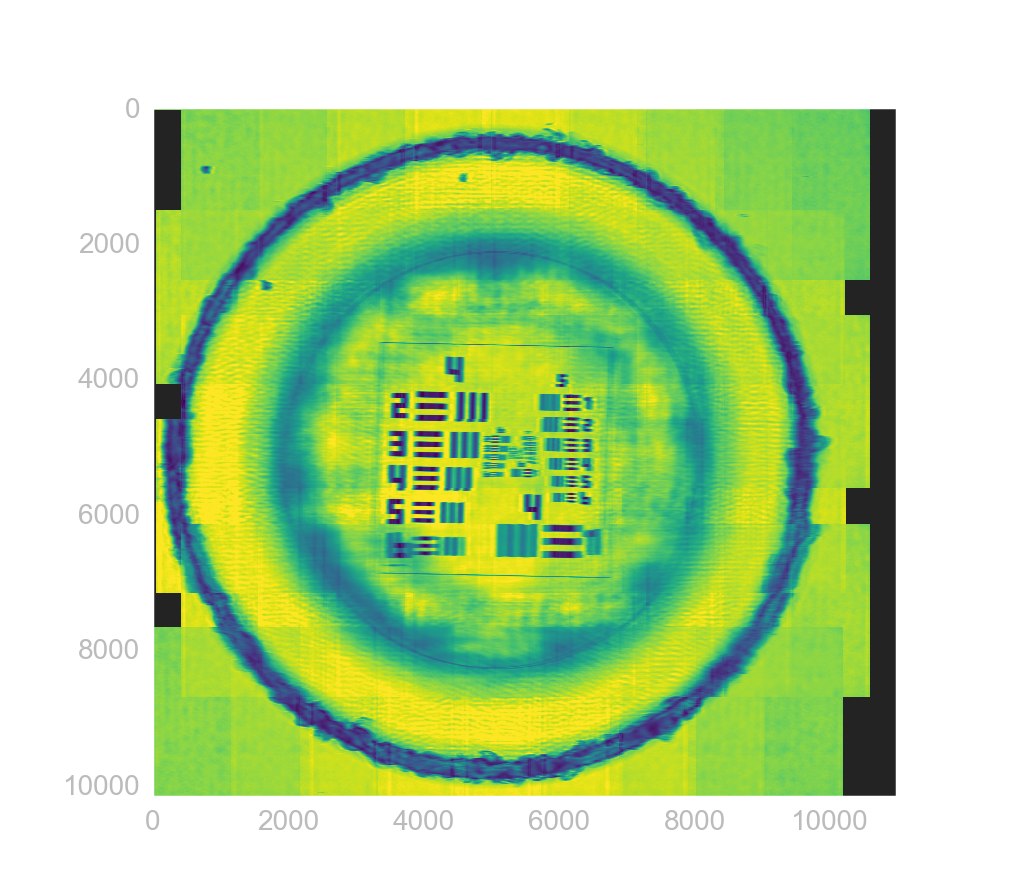

In [29]:

# O = obj_list[0].copy()
# O += np.roll(obj_list[1], (0,-400))
# mask[np.roll(obj_list[1], (0,200)) > 0] += 1
# O/= mask
# 80,20

O = obj_list[0].copy()
mask = (O > 0).astype(np.int)
# 
O += np.roll(obj_list[1].copy(), (34,-400))
mask[np.roll(obj_list[1].copy(), (34,-400)) > 0] += 1

O += np.roll(obj_list[2].copy(), (15,0), axis=(0,1))
mask[np.roll(obj_list[2].copy(), (15,0), axis=(0,1)) > 0] += 1

O += np.roll(obj_list[3].copy(), (35,-360), axis=(0,1))
mask[np.roll(obj_list[3].copy(), (35,-360), axis=(0,1)) > 0] += 1

O += np.roll(obj_list[4].copy(), (50,0), axis=(0,1))
mask[np.roll(obj_list[4].copy(), (50,0), axis=(0,1)) > 0] += 1

O += np.roll(obj_list[5].copy(), (50,-400), axis=(0,1))
mask[np.roll(obj_list[5].copy(), (50,-400), axis=(0,1)) > 0] += 1

O /= mask
plt.figure()
# plt.imshow(scipy.misc.imresize(O*30000, np.round(np.asarray(O.shape) / 10).astype(np.int)))
plt.imshow(O,vmax=40000)

<IPython.core.display.Javascript object>


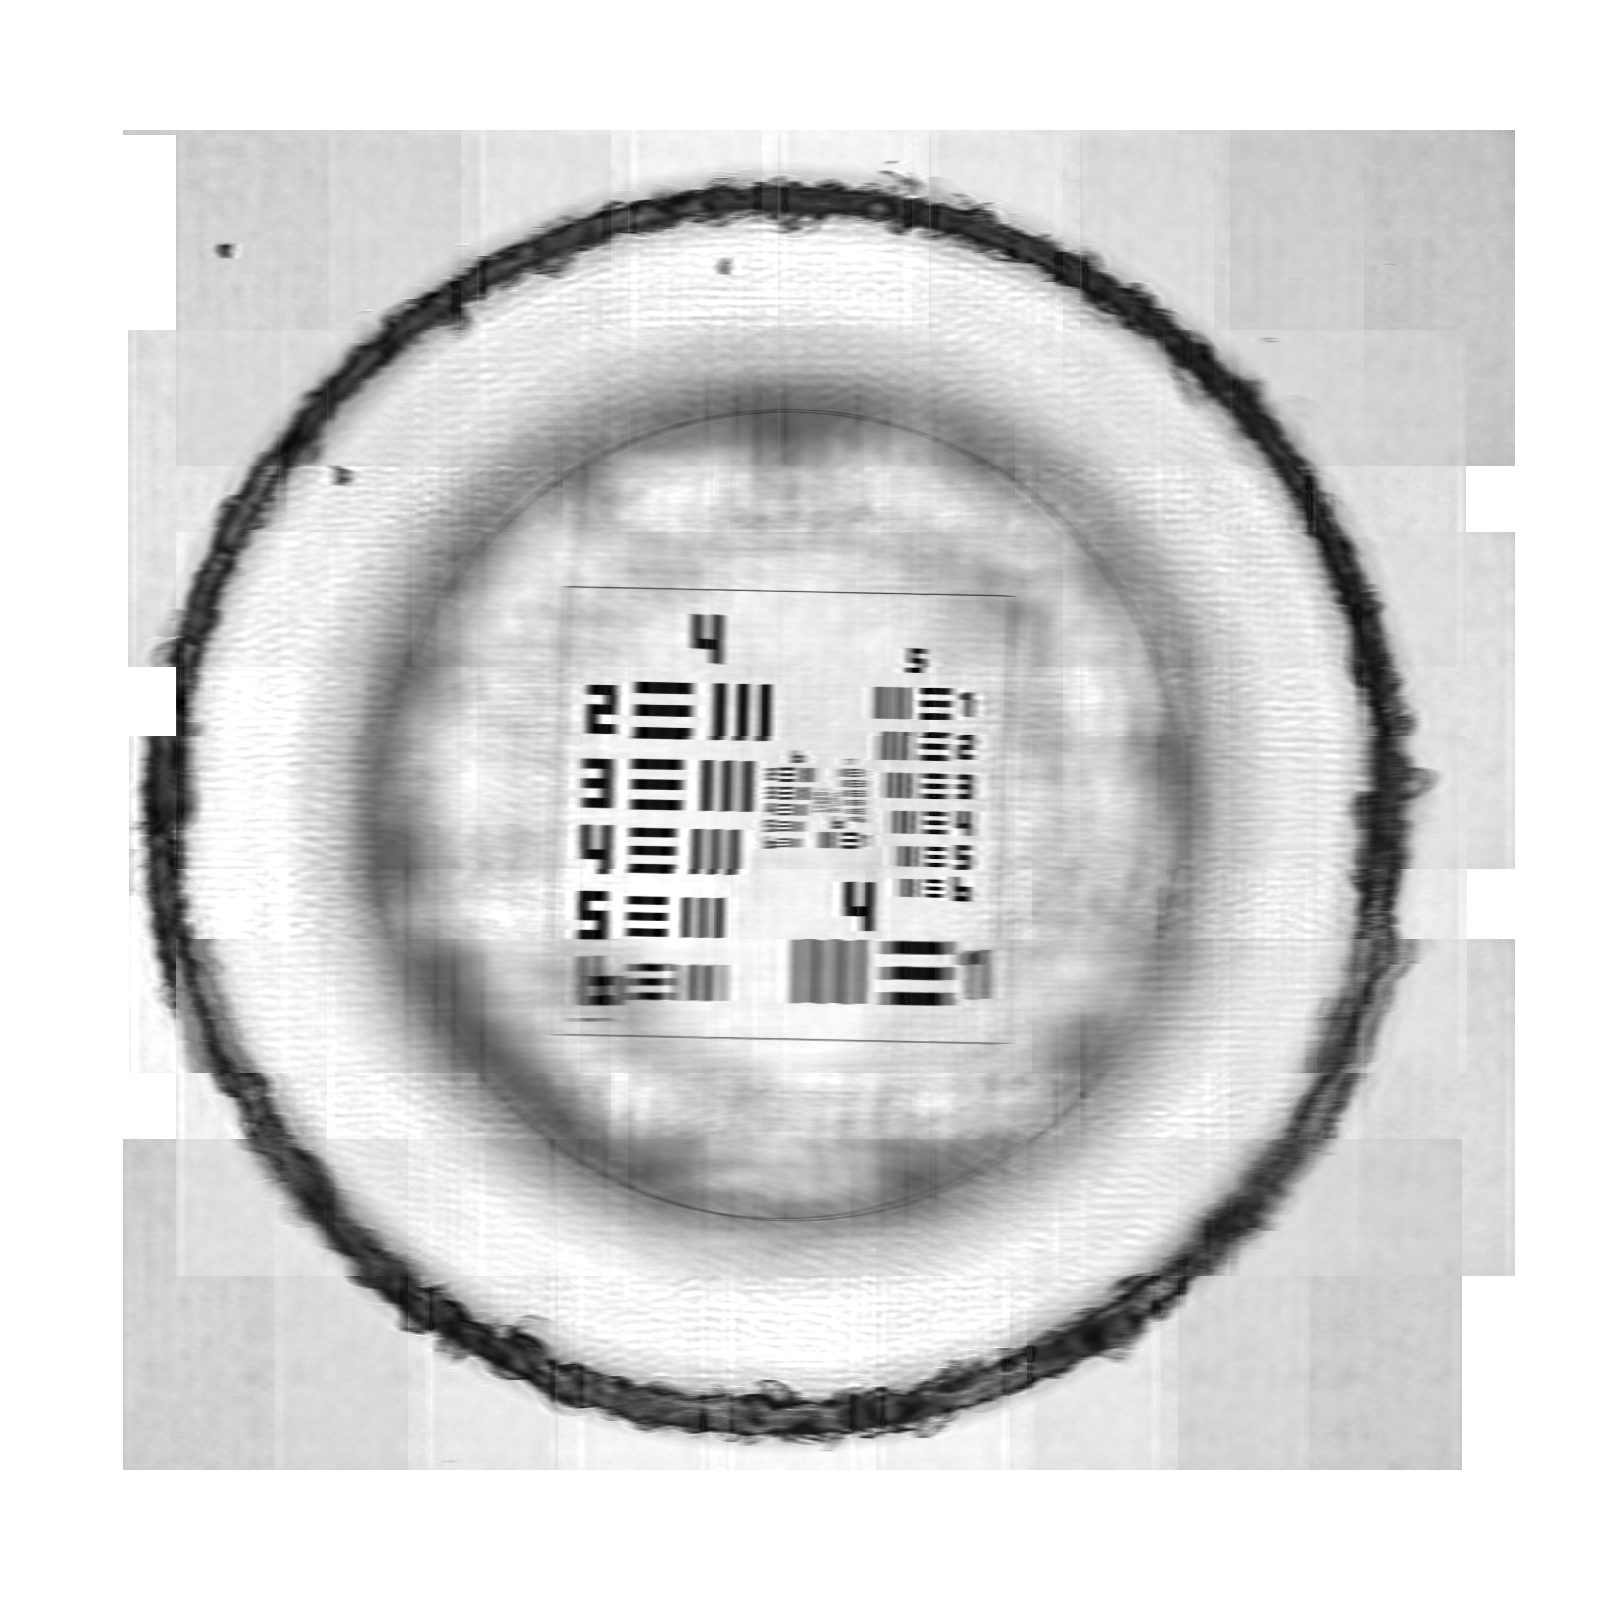

In [31]:
#     print(frame_index)
sample_name = 'usaf_coded'
plt.figure(figsize=(10,10))
im = plt.imshow(O, cmap='gray', vmax=40000)
plt.axis('off')
plt.tight_layout()
plt.savefig(fig_dir + '/' + sample_name + '.png', transparent=True, dpi=200)

In [ ]:
for obj_index in range(1, len(obj_list)):
    shift = opticstools.registerImage(obj_list[obj_index-1], obj_list[obj_index])

In [ ]:
# import copy
# # Calculate initial positions
# position_list = []`
# for frame_index in range(len(dataset.frame_list)):
#     position_dict = dataset.frame_state_list[frame_index]['position'][0][0]['value']
#     position_list.append(np.round(np.asarray((position_dict['x'], position_dict['y'])) / (dataset.metadata.system.eff_pixel_size_um/1000)).astype(np.int))
    
# position_list_corrected = copy.deepcopy(position_list)
# # confidence_interval = 400
# # # Register frames
# # for frame_index in range(1, len(dataset.frame_list)):
# #     (shift, _, __) = skimage.feature.register_translation(dataset.frame_list[frame_index - 1].astype(np.float32), dataset.frame_list[frame_index].astype(np.float32))
# #     new_position = position_list_corrected[frame_index - 1] + shift
# #     if np.linalg.norm(new_position - position_list_corrected[frame_index]) < confidence_interval:
# #         position_list_corrected[frame_index] = new_position
# #     else:
# #         position_list_corrected[frame_index] = position_list_corrected[frame_index]
# #         print('Ignoring shift!')
# #     print('Finished registering frame %d of %d' % (frame_index, len(dataset.frame_list)))


# position_list = np.asarray(position_list)
# position_list_corrected = np.asarray(position_list_corrected)

# if flip_y:
#     position_list[:,0] *= -1
#     position_list_corrected[:,0] *= -1
# if transpose_measurements:
#     position_list = np.fliplr(position_list)
#     position_list_corrected = np.fliplr(position_list_corrected)

In [ ]:
# Get object_size, and image_size
(object_size, image_size, blur_kernel_list_color) = blurkernel.blurKernelsFromDataset(dataset, frame_list=[0], flip_kernels=flip_y, transpose_measurements=transpose_measurements)
# object_size[0] += 100 # pad for path calibration
# object_size[1] += 100 # pad for path calibration

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(object_recon/ measurement_counts, vmax=1500)

In [ ]:
plt.figure()
plt.imshow(measurement_counts)

In [ ]:
frame_index = 10

(shift, _, __) = skimage.feature.register_translation(dataset.frame_list[frame_index - 1].astype(np.float32), dataset.frame_list[frame_index].astype(np.float32))
new_position = position_list_corrected[frame_index - 1] - shift
if np.linalg.norm(new_position - position_list_corrected[frame_index]) < confidence_interval:
#     position_list_corrected[frame_index] = new_position
    pass
else:
#     position_list_corrected[frame_index] = position_list_corrected[frame_index]
    print('Ignoring shift with norm %.2f' % np.linalg.norm(new_position - position_list_corrected[frame_index]))

In [ ]:
4.13
3.14
2.59

## Generate Blur Kernels from Metadata

In [ ]:
# Get blur_kernel_list, object_size, and image_size
(object_size, image_size, blur_kernel_list_color) = blurkernel.blurKernelsFromDataset(dataset, frame_list=[0])

In [ ]:
print(roi)

In [ ]:
print(roi)

In [ ]:
plt.figure()
plt.imshow( dataset.frame_list[20])

In [ ]:
# Get blur_kernel_list, object_size, and image_size
(object_size, image_size, blur_kernel_list_color) = blurkernel.blurKernelsFromDataset(dataset, 
                                                                                      flip_kernels=True, 
                                                                                      debug=False, 
                                                                                      use_phase_ramp=False)

# Sum the color channels of all blur kernels (TEMPORARY)
blur_kernel_list = []
for index, blur_kernel in enumerate(blur_kernel_list_color):
    first_channel = list(blur_kernel.keys())[0]
    new_kernel = np.zeros(object_size, dtype=blur_kernel[first_channel].dtype)
    for channel in blur_kernel:
        new_kernel += blur_kernel[channel]
    blur_kernel_list.append(new_kernel)

# Recover Object

## Single-Frame Recovery

In [ ]:
frame_index = 3
# Get measurement
y = dataset.frame_list[frame_index][dataset.metadata.camera.roi.y_start:dataset.metadata.camera.roi.y_end,
                                    dataset.metadata.camera.roi.x_start:dataset.metadata.camera.roi.x_end].reshape(-1).astype(np.complex64)
y /= np.mean(y)

# Get Blur Kernel and crop to correct size
blur_kernel = blur_kernel_list[frame_index]
kernel_support_roi = blurkernel.getBoundingBox(blur_kernel, return_roi=True)
assert np.all(np.asarray(kernel_support_roi.size()) < image_size)

center = kernel_support_roi.center()
# center[1] = kernel_support_roi,x)s
kernel_crop = blur_kernel[center[0] - image_size[0] // 2:center[0] + image_size[0] // 2,
                          center[1] - image_size[1] // 2:center[1] + image_size[1] // 2]

# Forward operator
A = ops.Convolution(image_size, kernel_crop, mode='windowed')

# Initialization: choosing a "good" coefficient value will help in convergence
initialization = np.ones(y.shape, y.dtype)

# Define cost function
objective = objectivefunctions.L2(A, y, reg=5e-3)

# Gradient descent implementation
iteration_count = 20
object_recovered = iterative.GradientDescent(objective).solve(initialization=initialization, 
                                                              step_size=1,
                                                              nesterov_enabled=True,
                                                              iteration_count=iteration_count, 
                                                              display_type='text', 
                                                              display_iteration_delta=max((iteration_count // 10),1))

In [ ]:
plt.figure(figsize=(12,5))
vmax = 2
plt.subplot(131)
plt.imshow(np.abs(y.reshape(image_size)), cmap='gray', vmax=vmax)
plt.title('Raw Data')
plt.subplot(132)
plt.imshow(np.abs(kernel_crop.reshape(image_size)), cmap='gray', vmax=vmax)
plt.title('Blur kernel')
plt.subplot(133)
plt.imshow(np.abs(object_recovered.reshape(image_size)), cmap='gray', vmax=vmax)
plt.title('Reconstruction')

## Multi-Frame Gradient Descent

In the gradient-based model, we model the system using the same forward model as before:

$$
    I_j = diag(W) F^{-1} diag(\tilde{H}_j)  diag(\tilde{O})
$$

Written in matrix form $\forall j$, the forward model is given by:

\begin{equation*}
\begin{pmatrix} 
I_1 \\ I_2 \\ I_3
\end{pmatrix}
=
\begin{pmatrix}
W F^{-1}diag(\tilde{H}_1) \\
W F^{-1}diag(\tilde{H}_2) \\
W F^{-1}diag(\tilde{H}_2) \\
\end{pmatrix}
\begin{pmatrix} 
\tilde{O}
\end{pmatrix}
\end{equation*}

The issue here is that due to the real space and Fourier space implementation, the sub-matricies are not diagonalizable. Therefore inversion is not as simple as a standard deconvolution.

Since this problem is linear (and convex), we can take the gradient of the data fidality, $f(x) = ||Ax - I||^2_2$:

$$ \nabla_x f(x) = A^H (Ax - I) $$

$$ \nabla_x f(x) = A^H Ax - A^H I = 0 $$

$$A^H A x =  A^H I$$

Where,

$$
A=\begin{pmatrix}
W F^{-1}diag(\tilde{H}_1) \\
W F^{-1}diag(\tilde{H}_2) \\
W F^{-1}diag(\tilde{H}_2) \\
\end{pmatrix}
$$

Plugging in,
$$
\begin{pmatrix}
diag(\tilde{H}_1^*) F W^T &
diag(\tilde{H}_2^*) F W^T &
diag(\tilde{H}_2^*) F W^T
\end{pmatrix}
\begin{pmatrix}
W F^{-1}diag(\tilde{H}_1) \\
W F^{-1}diag(\tilde{H}_2) \\
W F^{-1}diag(\tilde{H}_2) \\
\end{pmatrix}
\tilde{O} =
\begin{pmatrix}
diag(\tilde{H}_1^*) F W^T &
diag(\tilde{H}_2^*) F W^T &
diag(\tilde{H}_2^*) F W^T
\end{pmatrix}
\begin{pmatrix} 
I_1 \\ I_2 \\ I_3
\end{pmatrix}
$$

$$
\sum_j{diag(\tilde{H}_j^*) F W^T W F^{-1}diag(\tilde{H}_j)} \tilde{O}  = \sum_j diag(\tilde{H}_1^*) F W^T I_j
$$


In [ ]:
frame_roi = dataset.metadata.camera.roi

# Determine maximum kernel support in x/y for all blur kernels in blur_kernel_list. This is how much we will pad our object by.
support_size_list = []
for blur_kernel in blur_kernel_list:
    support_size_list.append(blurkernel.getBoundingBox(blur_kernel, return_roi=True).size())
max_kernel_support = np.max(np.asarray(support_size_list),axis=0) - 1

# Generate pad operator for object support
object_size_padded = (np.asarray(object_size) + max_kernel_support).tolist() # Add to object_size
W_object_support = ops.Crop(object_size_padded, object_size, crop_start=(max_kernel_support[0] // 2, max_kernel_support[1] // 2)) # Add support

# Define crop operator for object to image
W = ops.Crop(object_size, image_size)

A_list = []
y_list = []
C_list = []

# Generate forward model operators for each blur kernel
for blur_kernel_index, blur_kernel in enumerate(blur_kernel_list):
    blur_kernel = blur_kernel.astype(np.complex64) / np.sum(np.abs(blur_kernel.astype(np.complex64)))
    
    # 2D Convolution Operator with the given kernel
#     C = ops.Convolution(object_size_padded, (W_object_support.H * blur_kernel.reshape(-1)).reshape(object_size_padded), label='C' + str(blur_kernel_index))
    C = ops.Convolution(object_size, blur_kernel)
    C_list.append(C)
    
    # Forward operator with image crop and full object crop
    A_list.append(W * C)
    
    # Measurements (from dataset)
    y_list.append(dataset.frame_list[blur_kernel_index][frame_roi.y_start:frame_roi.y_end,frame_roi.x_start:frame_roi.x_end].astype(np.complex64))
    
    # Print results to terminal
    print('Generated Measurement and forward model object %d of %d' % (blur_kernel_index + 1, len(blur_kernel_list)))

# Concatenate measurements vertically    
y_full = np.empty(0, dtype=np.complex64)
for y in y_list:
    y_full = np.append(y_full, y)
    
# Normalize measurements
y_mean = np.mean(np.abs(y_full))  
y_full /= y_mean

# Generate full A Operator
A_full = ops.Vstack(Operators=A_list)


## Multi-frame  Recovery

In [ ]:
# Concatenate measurements vertically    
y_full = np.empty(0, dtype=np.complex64)
for y in y_list:
    y_full = np.append(y_full, y)
    
# Normalize measurements
y_mean = np.mean(np.abs(y_full))  
y_full /= y_mean

# Generate full A Operator
A_full = ops.Vstack(Operators=A_list)

# Initialization: choosing a "good" coefficient value will help in convergence
initialization = np.ones(object_size, dtype=np.complex64).reshape(-1)

# Define cost function
objective = objectivefunctions.L2(A_full, y_full, reg=1e-3)

# Gradient descent implementation
iteration_count = 20
object_recovered = iterative.GradientDescent(objective).solve(initialization=initialization, 
                                                              step_size=0.5,
                                                              nesterov_enabled=True,
                                                              iteration_count=iteration_count, 
                                                              display_type='text', 
                                                              display_iteration_delta=max((iteration_count // 10), 1))

## Show Results

In [1]:
import arrayfire
arrayfire.stdev

('libforge.1.dylib', '/opt/arrayfire/lib/libforge.1.dylib')


In [ ]:
# object_recovered_crop = (W_object_support * object_recovered).reshape(object_size)
object_recovered_crop = object_recovered.reshape(object_size)

if dataset.metadata.simulation.object_true is not None:
    # Load true object
    object_true_normalized = np.asarray(dataset.metadata.simulation.object_true)
    object_true_normalized /= np.mean(object_true_normalized) # Noamlize to be zero-mean
    # Calculate SSE
    print('Recovery SSE is %.2f' % np.sum(np.abs(object_true_normalized - object_recovered_crop) ** 2))

    plt.figure(figsize=(12, 3)) 
    plt.subplot(1,3,1); i_true = plt.imshow(np.abs(object_true_normalized), cmap='gray'); plt.title('Ground Truth')
    plt.subplot(1,3,2); i_rec = plt.imshow(np.abs(object_recovered_crop), cmap='gray'); plt.title('Recovered');# i_rec.set_clim(i_true.get_clim())
    plt.subplot(1,3,3); plt.imshow(np.abs(object_true_normalized- object_recovered_crop), cmap='gray'); plt.colorbar(); plt.title('Difference')
else:
    plt.figure(figsize=(7, 9)) 
    plt.subplot(1,1,1); i_rec = plt.imshow(np.abs(object_recovered_crop), cmap='gray', vmax=1.5); plt.title('Recovered');# i_rec.set_clim(i_true.get_clim())